# Case Study: Unterstanding Mental Health in Technology-Related Companies (Script 2)
## Data Preprocessing and Feature Engineering (continued)

Overview
* this script represents the continuation of the data preprocessing and feature engineering process
* due to the length of the first script, the data preprocessing and feature engineering process was split into two scripts

## 1 Imports and General Settings

In [1]:
import functions_mhd as f 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import kendalltau 
import seaborn as sns 

In [2]:
# set the pandas options to show all columns, all rows and the entire cell content of data frames
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 

# set style of seaborn graphics 
sns.set_theme(style='ticks', color_codes=True)

In [3]:
# load the data
df_v5 = pd.read_csv('df_v5.csv')

## 2 Extracting Further Variables

Overview
* extract information about who has already disclosed their mental disorder including the consequences
* extract information about who has had negative experiences due to disclosing mental disorders
* identify inconsistent data records based on the extracted information
* create new variables that capture the difference in evaluations of physical and mental problems
* add the suicide rate based on the area of residency as an indicator of stigmatization of mental problems (Oexle et al., 2018, p. 173)
* extract the length of responses as features to indicate the personal importance of a topic

### 2.1 Disclosing Mental Disorders and Job Related Effects

* three variables can be used to find out who has already definitely disclosed their mental disorder
* these three variables record which negative consequences are expected when disclosing a mental disorder
* for two of the three variables, the answers are formulated in the subjunctive and indicative moods
* subjects who chose the indicative answer are assumed to have already disclosed their mental disorder 
* it should be noted that for subjects who chose "maybe" it is not clear whether they have disclosed their mental disorder
* for the third question, those who chose "I experienced" (instead of "I observed") disclosed their mental disorder 
* the three variables can also be used to create a new variable capturing job-related negative experiences due to disclosing mental disorders

value counts of mhd_disclosed_career :


,count,percent
0,531,0.469496
Not applicable to me,510,0.450928
1,90,0.079576


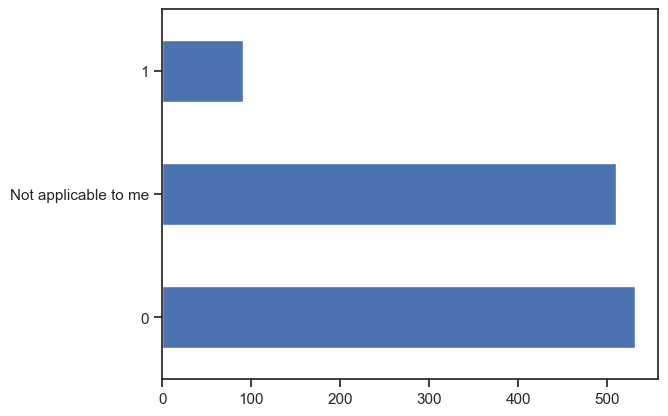

value counts of mhd_disclosed_coworkers :


,count,percent
0,559,0.494253
Not applicable to me,510,0.450928
1,62,0.054819


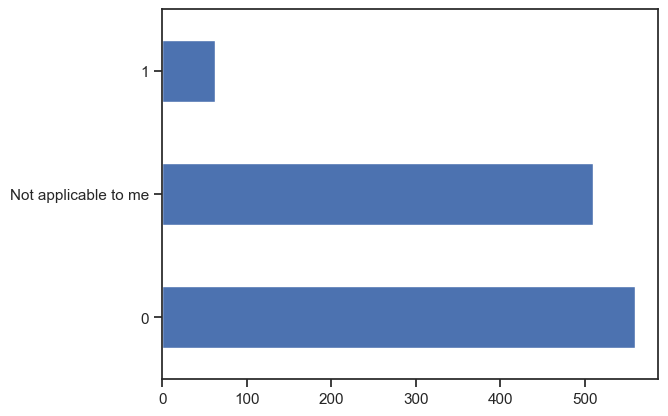

value counts of bad_response_experienced :


,count,percent
Not applicable to me,510,0.450928
0.0,491,0.434129
1.0,114,0.100796
NaN,16,0.014147


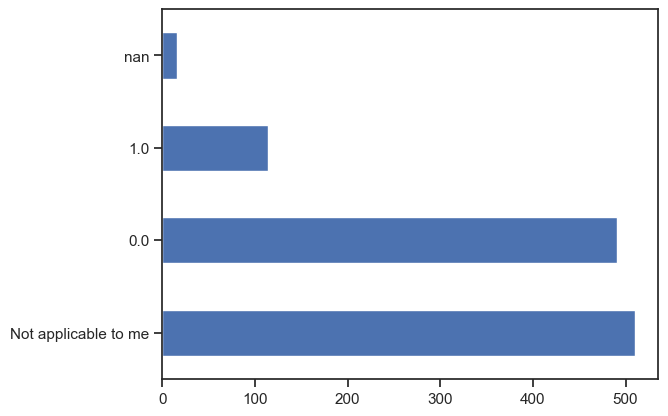

In [4]:
# create new variables capturing who has definitely disclosed their mental disorder and who has not
def add_disclosed_var(var_basis, new_var_name, data, options_list):
    """add a variable to the dataset that encodes which individuals chose one of the specified options in another variable 
    
    :param var_basis: the name of the variable, on which the new variable is based ('str')
    :param new_var_name: the name of the variable to be created ('str')  
    :param data: the data source of the variables ('pandas.core.frame.DataFrame')
    :param options_list: the options of the old variable used to create the new variable ('list')
    """
    
    disclosed = data[var_basis]
    data[new_var_name] = [np.nan if pd.isnull(val) else 1 if val in options_list else 0 for val in disclosed]
    data.loc[data['mhd_anytime'] != 'Yes', new_var_name] = 'Not applicable to me'  # code individuals without a definite mental disorder as not applicable 

add_disclosed_var('mh_disclosure_expected_neg_effect_career', 'mhd_disclosed_career', df_v5, ['Yes, it has', 'No, it has not'])
add_disclosed_var('mh_disclosure_expected_neg_view_coworkers', 'mhd_disclosed_coworkers', df_v5, ['Yes, they do', 'No, they do not'])
add_disclosed_var('mh_neg_effect_workplace_observed', 'bad_response_experienced', df_v5, ['Yes, I experienced'])

f.explore_feature(df_v5['mhd_disclosed_career'], original=False)
f.explore_feature(df_v5['mhd_disclosed_coworkers'], original=False)
f.explore_feature(df_v5['bad_response_experienced'], original=False)

Observations
* 5-10% of respondents disclosed their mental disorder 

In [5]:
# check whether the same individuals disclosed their mental health disorder
display(df_v5.groupby(['mhd_disclosed_career', 'mhd_disclosed_coworkers', 'bad_response_experienced'], dropna=False).size())

mhd_disclosed_career  mhd_disclosed_coworkers  bad_response_experienced
0                     0                        0.0                         417
                                               1.0                          68
                                               NaN                          14
                      1                        0.0                          27
                                               1.0                           5
1                     0                        0.0                          35
                                               1.0                          24
                                               NaN                           1
                      1                        0.0                          12
                                               1.0                          17
                                               NaN                           1
Not applicable to me  Not applicable to me     Not applicab

Observations
* only 17 indivividuals selected an option suggesting disclosure of their mental disorders on all three variables 
* it is possible that some have disclosed the mental disorder only to their colleagues and others only to their bosses 

value counts of mhd_disclosed :


,count,percent
Not applicable to me,510,0.450928
0,499,0.441202
1,122,0.107869


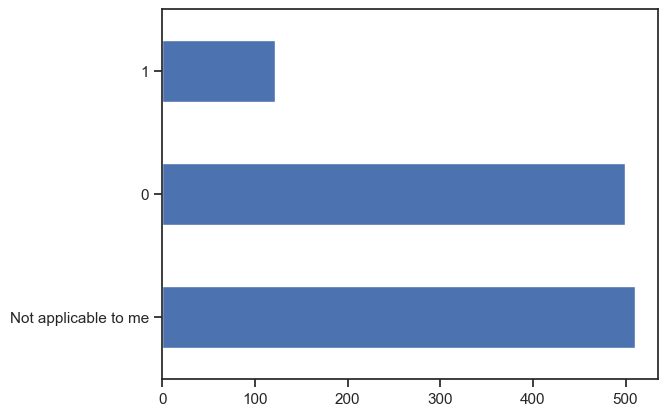

In [6]:
# create a variable that captures whether someone has disclosed their mental disorder, regardless of context
# the variable bad_response_experienced is not used for this purpose as this variable contains only negative responses and no positive reponses 
disclosed_career = df_v5['mhd_disclosed_career']
disclosed_coworker = df_v5['mhd_disclosed_coworkers']
disclosed = ['Not applicable to me' if car == 'Not applicable to me' else 1 if (car == 1) or (cow == 1) else 0 for car, cow in zip(disclosed_career, disclosed_coworker)]
df_v5['mhd_disclosed'] = disclosed

f.explore_feature(df_v5['mhd_disclosed'], original=False)

Observations
* in total, 122 individuals have disclosed their mental health disorder, regardless of context

In [7]:
# check whether there are any individuals who have disclosed their mental disorders but indicated not having had a mental disorder
df_group_mhd = df_v5.groupby('mhd_anytime', dropna=False)
display(df_group_mhd['mh_disclosure_expected_neg_effect_career'].value_counts(dropna=False))
display(df_group_mhd['mh_disclosure_expected_neg_view_coworkers'].value_counts(dropna=False))
display(df_group_mhd['mh_neg_effect_workplace_observed'].value_counts(dropna=False))

mhd_anytime  mh_disclosure_expected_neg_effect_career
Maybe        Maybe                                        92
             Yes, I think it would                        84
             No, I don't think it would                   19
             Yes, it has                                   7
             No, it has not                                3
No           Maybe                                       151
             Yes, I think it would                       119
             No, I don't think it would                   32
             Yes, it has                                   3
Yes          Yes, I think it would                       238
             Maybe                                       223
             No, I don't think it would                   70
             Yes, it has                                  68
             No, it has not                               22
Name: mh_disclosure_expected_neg_effect_career, dtype: int64

mhd_anytime  mh_disclosure_expected_neg_view_coworkers
Maybe        Maybe                                         87
             Yes, I think they would                       64
             No, I don't think they would                  45
             No, they do not                                6
             Yes, they do                                   3
No           Maybe                                        129
             No, I don't think they would                 105
             Yes, I think they would                       70
             Yes, they do                                   1
Yes          Maybe                                        240
             Yes, I think they would                      167
             No, I don't think they would                 152
             No, they do not                               38
             Yes, they do                                  24
Name: mh_disclosure_expected_neg_view_coworkers, dtype: int64

mhd_anytime  mh_neg_effect_workplace_observed
Maybe        No                                   85
             Maybe/Not sure                       57
             Yes, I observed                      40
             Yes, I experienced                   12
             NaN                                  11
No           No                                  177
             Maybe/Not sure                       64
             Yes, I observed                      38
             NaN                                  24
             Yes, I experienced                    2
Yes          No                                  226
             Maybe/Not sure                      151
             Yes, I experienced                  114
             Yes, I observed                     114
             NaN                                  16
Name: mh_neg_effect_workplace_observed, dtype: int64

Observations
* for each question, between 10 and 14 individuals chose an answer in the indicative or "I experienced", although none of them has/had a mental disorder

In [8]:
# code the 10-14 individuals per question as inconsistent
index_disclosed_no_mhd = df_v5.index[((df_v5['mhd_anytime'] != 'Yes') & ((df_v5['mh_disclosure_expected_neg_effect_career'] == 'Yes, it has') | 
                                                                        (df_v5['mh_disclosure_expected_neg_view_coworkers'] == 'Yes, they do') |
                                                                        (df_v5['mh_neg_effect_workplace_observed'] == 'Yes, I experienced')))]

# change the data type of "reason_inconsistent" to 'str' to avoid an error 
df_v5['reason_inconsistent'] = df_v5['reason_inconsistent'].fillna('')

# code the 10-14 individuals per question as inconsistent
f.code_as_inconsistent(index_disclosed_no_mhd, 'did not indicate an mhd but disclosed an mhd |', df_v5)

value counts of neg_experiences :


,count,percent
Not applicable to me,510,0.450928
0.0,453,0.400531
1.0,153,0.135279
NaN,15,0.013263


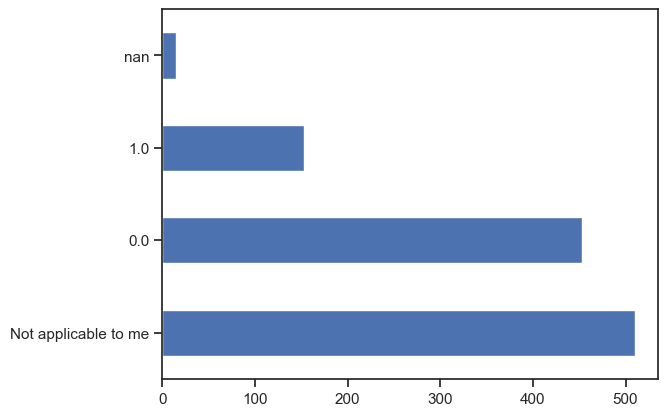

In [9]:
# create a variable that captures whether someone has definitely (not "maybe") experienced job-related negative effects/reactions due to mental health issues
neg_effect_career = df_v5['mh_disclosure_expected_neg_effect_career'].replace(['Maybe', 'No, I don\'t think it would', 'Yes, I think it would', 'No, it has not', 'Yes, it has'], 
                                                                              [0, 0, 0, 0, 1]) 
neg_effect_view = df_v5['mh_disclosure_expected_neg_view_coworkers'].replace(['No, I don\'t think they would', 'Maybe', 'Yes, they do', 'Yes, I think they would', 'No, they do not'],
                                                                            [0, 0, 1, 0, 0])
neg_response = df_v5['mh_neg_effect_workplace_observed'].replace(['No', 'Maybe/Not sure', 'Yes, I experienced', 'Yes, I observed'], [0, 0, 1, 0])

df_v5['neg_experiences'] = [0 if car + cow + res == 0 else 1 if (car == 1) | (cow == 1) | (res == 1) else np.nan 
                            for car, cow, res in zip(neg_effect_career, neg_effect_view, neg_response)]

# recode individuals without mental health disorders as "not applicable" (n/a)
df_v5.loc[df_v5['mhd_anytime'] != 'Yes', 'neg_experiences'] = 'Not applicable to me'

f.explore_feature(df_v5['neg_experiences'], original=False)

Observations
* 14% of respondents have definitely experienced negative effects/reactions at work due to mental health issues

### 2.2 Difference Between Physical and Mental Health

* several questions are asked in relation to both mental and physical problems 
* new variables are created by taking the difference between the rating of mental and physical problems
* if physical problems score better than mental problems, this indicates that mental problems are stigmatized 

value counts of discuss_diff_mental_physical :


,count,percent
0,627,0.554377
1,407,0.359859
2,86,0.076039
-1,11,0.009726


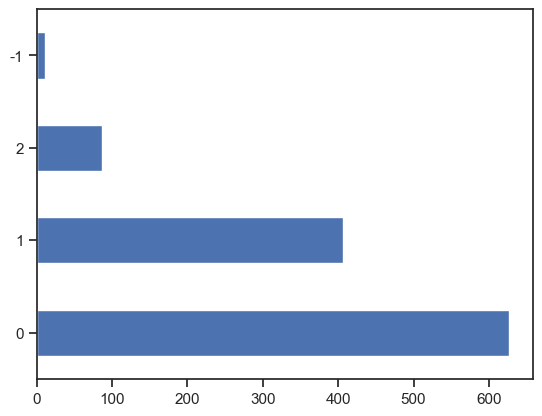

In [10]:
# create a variable that measures the difference in expected negative consequences after disclosure of physical vs. mental problems 
# the higher the value, the more negative the consequences expected when discussing mental compared to physical problems 

def calculate_difference(feature_minuend, feature_subtrahend, replace_minuend=[['No', 'Maybe', 'Yes'], [0, 1, 2]], replace_subtrahend=[['No', 'Maybe', 'Yes'], [0, 1, 2]]):
    """subtract one variable from the other by first encoding the values of the features numerically 
    
    :param feature_minuend: the feature from which the values of the other feature are to be subtracted ('pandas.core.series.Series')
    :param feature_subtrahend: the feature serving as the subtrahend ('pandas.core.series.Series')  
    :param replace_minuend: a list of lists containing information about how to numerically encode feature values of the minuend variable ('list')
    :param replace_subtrahend: a list of lists containing information about how to numerically encode feature values of the subtrahend variable ('list')
    :return: the difference between the two features ('str')
    """
    
    minuend = feature_minuend.replace(replace_minuend[0], replace_minuend[1])
    subtrahend = feature_subtrahend.replace(replace_subtrahend[0], replace_subtrahend[1])
    return minuend - subtrahend 
    
df_v5['discuss_diff_mental_physical'] = calculate_difference(df_v5['employer_neg_conseq_mh_disclosure_expected'], df_v5['employer_neg_conseq_physical_disclosure_expected'])

f.explore_feature(df_v5['discuss_diff_mental_physical'], original=False)

Observations
* more than half of respondents (55%) do not expect more negative consequences if they discuss mental compared to physical issues with their employer 
* only 11 individuals expect more negative consequences when discussing a physical health issue as compared to discussing a mental health issue
* 44% expect more negative consequences when discussing a mental health issue than when discussing a physical health issue

value counts of diff_willingness_mental_physical_interview :


,count,percent
0,637,0.563218
-1,370,0.327144
-2,99,0.087533
1,22,0.019452
2,3,0.002653


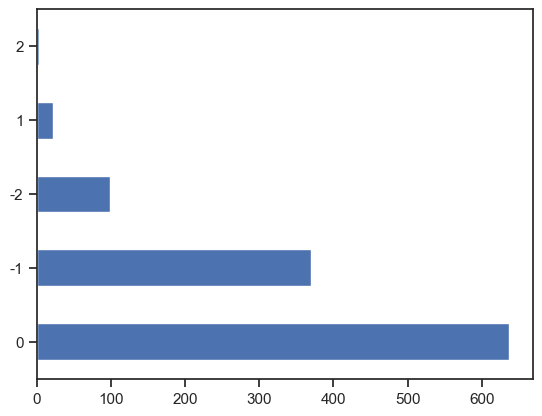

In [11]:
# create a variable that measures the difference in the willingness to disclose a mental vs. a physical health issue in a job interview  
# the lower the value, the less willing individuals are to disclose mental as compared to physical health issues in a job interview 
df_v5['diff_willingness_mental_physical_interview'] = calculate_difference(df_v5['willingness_mh_disclosure_interview'], df_v5['willingness_physical_disclosure_interview'])

f.explore_feature(df_v5['diff_willingness_mental_physical_interview'], original=False)

Observations
* 56% did not indicate a difference in their willingness to disclose a physical vs. mental health issue in a job interview 
* 42% would feel less comfortable discussing a mental health issue than a physical health issue 
* only 2% would prefer to talk about mental health problems rather than physical health problems in an interview

Conclusions
* mental health issues are stigmatized

### 2.3 Differences Due to the Receiver of the Information

* two variables capture how comfortable one would feel telling the supervisor, or coworkers, about a mental health problem
* a new variable is created as the difference between the two variables, as individuals may differ in whether they would prefer to open up to their supervisor or to their coworkers

value counts of discussing_diff_coworker_supervisor :


,count,percent
0,680,0.601238
-1,294,0.259947
1,118,0.104332
-2,28,0.024757
2,11,0.009726


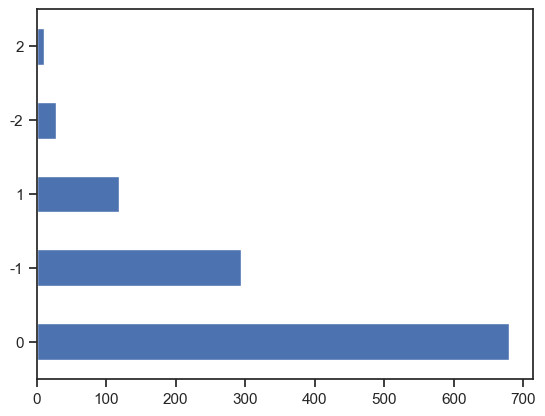

In [12]:
# create a variable that measures the difference between the willingness to discuss mental problems with the supervisor and the willingness to do so with coworkers 
# the lower the value, the less comfortable individuals are opening up to their coworkers compared to their supervisors  
    
df_v5['discussing_diff_coworker_supervisor'] = calculate_difference(df_v5['mh_disclosure_coworker_comfortable'], df_v5['mh_disclosure_supervisor_comfortable'])

f.explore_feature(df_v5['discussing_diff_coworker_supervisor'], original=False)

Observations
* 60% see no difference between coworkers and direct supervisors 
* 28% say that discussing a mental health issue with coworkers is worse than with the direct supervisor
* 11% say that discussing a mental health issue with coworkers is better than discussing it with the direct supervisor

### 2.4 Effect of Treatment on Work

* two variables capture the effect of the mental disorder on work when it is effectively treated and when it is not treated
* a new variable is created as the difference between the two variables, indicating what effect individuals attribute to treatment 

value counts of diff_neg_effect_treated_vs_not_treated :


,count,percent
Not applicable to me,613,0.541998
positive effect of treatment,420,0.371353
no effect of treatment,95,0.083996
negative effect of treatment,3,0.002653


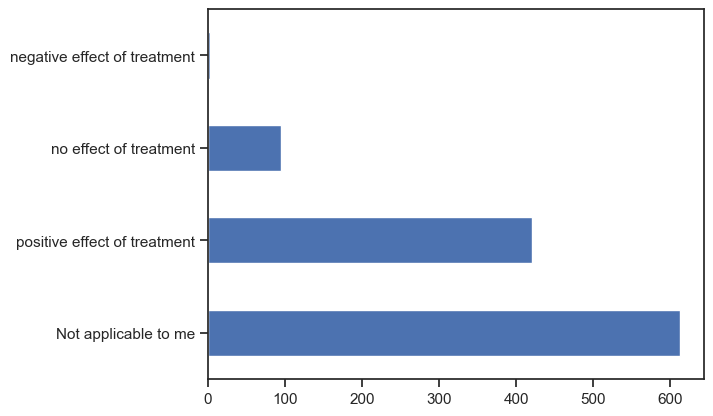

In [13]:
# create a variable that measures the difference between the effect of the mental disorder on work when it is effectively treated and when it is not treated
df_v5['diff_neg_effect_treated_vs_not_treated'] = calculate_difference(df_v5['neg_effect_work_not_treated'], df_v5['neg_effect_work_treated'], 
                                                                       [['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'], [100, 0, 1, 2, 3]],
                                                                       [['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'], [50, 0, 1, 2, 3]]) 
# n/a responses are also numerically encoded to be abe to calculate the difference; they will be replaced after calculating the difference
# due to the n/a option, this variable is nominal 
def identify_diff_treat(val):
    """correctly categorize values according to their contextual meaning  
    
    :param val: the value to be categorized ('int')
    :return: the categorization of the value ('str')
    """
    
    if abs(val) > 40:
        return 'Not applicable to me'
    elif val == 0:
        return 'no effect of treatment'
    elif val > 0:
        return 'positive effect of treatment'
    elif val < 0:
        return 'negative effect of treatment'
    
df_v5['diff_neg_effect_treated_vs_not_treated'] = df_v5['diff_neg_effect_treated_vs_not_treated'].apply(identify_diff_treat)
f.explore_feature(df_v5['diff_neg_effect_treated_vs_not_treated'], original=False)

Observations
* 45% say that the effect of the mental health issue on work is less negative when it is treated effectively than when it is not
* 14% see no effect of treatment
* 9 individuals (< 1%) see a negative effect of treatment

### 2.5 Suicide Rate

* the suicide rate in a country/state can be considered as an indicator of the stigma associated with mental health problems (Oexle et al., 2018, p. 173)
* the dataset did not capture suicide rates, but it did query which country, or US state, individuals live and work in
* based on this information and several data sources (DC Health Matters, n.d.; World Health Organization, 2021; World Population Review, 2022), the suicide rate is added to the dataset
* first, it is decided whether to base it on the country/state, in which individuals work or in which they live

value counts of country_diff :


,count,percent
0,1121,0.991158
1,10,0.008842


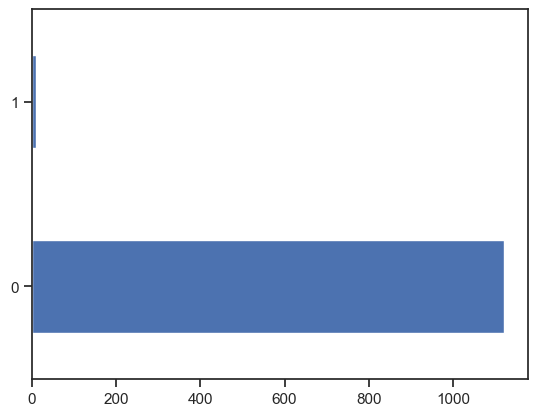

value counts of state_diff :


,count,percent
0,1085,0.959328
1,46,0.040672


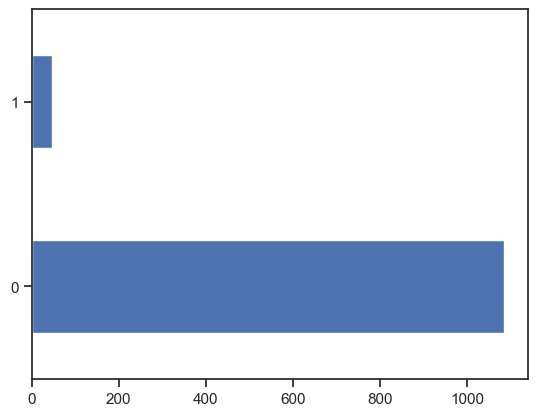

In [14]:
# compare the countries/states in which individuals work and live
country_diff = np.where((df_v5['country_live'] == df_v5['country_work']), 0, 1)
f.explore_feature(pd.Series(country_diff, name='country_diff'), original=False)

state_diff = np.where((df_v5['US_state_live'] == df_v5['US_state_work']), 0, 1)
f.explore_feature(pd.Series(state_diff, name='state_diff'), original=False)

Observations
* since less than 5% live in a different country/state than they work in, it does not really matter which feature is taken as the basis
* as the case study is about dealing with mental health problems in the work context, the work features are uses as the basis in the following

In [15]:
# extract the information about the suicide rate in each country
# load the data
df_suicide = pd.read_csv('suicide_country.csv')
print("original dataset: ")
display(df_suicide.head())

# retain only the first three columns
df_suicide_v2 = df_suicide[['Unnamed: 0', 'Unnamed: 1', 'Age-standardized suicide rates (per 100 000 population)']].copy()

# drop the first row
df_suicide_v2.drop(index=df_suicide_v2.index[0], axis=0, inplace=True)

# rename columns
df_suicide_v2.rename(columns={'Unnamed: 0': 'country_work', 'Unnamed: 1': 'sex', 
                              'Age-standardized suicide rates (per 100 000 population)': 'suicide_rate'}, inplace=True)

# keep only the "both sexes" row
df_suicide_v3 = df_suicide_v2.loc[df_suicide_v2['sex'] == ' Both sexes'].copy()

# drop sex column
df_suicide_v3.drop(columns='sex', inplace=True)

# retain only the information outside the brackets in the suicide rate
df_rates = df_suicide_v3['suicide_rate'].str.split(expand=True)
df_suicide_v3['suicide_rate'] = df_rates[0]
print("\nreduced dataset: ")
display(df_suicide_v3.head())

original dataset: 


,Unnamed: 0,Unnamed: 1,Age-standardized suicide rates (per 100 000 population),Age-standardized suicide rates (per 100 000 population).1,Age-standardized suicide rates (per 100 000 population).2,Age-standardized suicide rates (per 100 000 population).3,Age-standardized suicide rates (per 100 000 population).4,Age-standardized suicide rates (per 100 000 population).5,Age-standardized suicide rates (per 100 000 population).6,Age-standardized suicide rates (per 100 000 population).7,Age-standardized suicide rates (per 100 000 population).8,Age-standardized suicide rates (per 100 000 population).9,Age-standardized suicide rates (per 100 000 population).10,Age-standardized suicide rates (per 100 000 population).11,Age-standardized suicide rates (per 100 000 population).12,Age-standardized suicide rates (per 100 000 population).13,Age-standardized suicide rates (per 100 000 population).14,Age-standardized suicide rates (per 100 000 population).15,Age-standardized suicide rates (per 100 000 population).16,Age-standardized suicide rates (per 100 000 population).17,Age-standardized suicide rates (per 100 000 population).18,Age-standardized suicide rates (per 100 000 population).19
0,Country,Sex,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
1,Afghanistan,Both sexes,6.0 [3.4-9.9],5.9 [3.4-9.8],6.0 [3.4-9.9],6.0 [3.5-9.9],6.0 [3.5-9.9],6.0 [3.5-9.9],6.2 [3.6-10.2],6.2 [3.6-10.2],6.4 [3.8-10.5],6.7 [3.9-10.9],6.8 [4.0-11.1],7.2 [4.2-11.7],7.4 [4.3-12.1],7.6 [4.4-12.3],7.6 [4.4-12.3],7.8 [4.5-12.6],7.7 [4.5-12.5],7.9 [4.5-12.8],7.9 [4.5-12.8],7.7 [4.4-12.5]
2,Afghanistan,Male,6.2 [3.5-10.5],6.2 [3.5-10.4],6.3 [3.7-10.7],6.2 [3.6-10.3],6.1 [3.6-10.2],6.1 [3.6-10.2],6.3 [3.7-10.5],6.4 [3.7-10.5],6.6 [3.8-10.9],6.9 [4.0-11.3],7.0 [4.1-11.6],7.4 [4.3-12.2],7.7 [4.5-12.6],7.8 [4.5-12.7],7.8 [4.5-12.7],7.9 [4.5-12.9],7.8 [4.5-12.8],8.0 [4.6-13.1],7.9 [4.5-12.9],7.6 [4.4-12.5]
3,Afghanistan,Female,5.7 [3.2-9.2],5.6 [3.2-9.1],5.5 [3.1-9.0],5.8 [3.3-9.5],5.8 [3.3-9.4],5.9 [3.4-9.5],6.0 [3.5-9.8],6.1 [3.6-9.8],6.2 [3.7-10.1],6.4 [3.8-10.3],6.6 [3.9-10.5],6.9 [4.0-11.0],7.1 [4.2-11.4],7.3 [4.3-11.7],7.4 [4.3-11.9],7.6 [4.4-12.2],7.6 [4.5-12.2],7.7 [4.5-12.4],7.9 [4.6-12.6],7.8 [4.5-12.4]
4,Albania,Both sexes,3.7 [2.1-5.7],3.9 [2.2-6.0],4.1 [2.3-6.3],4.2 [2.3-6.3],4.2 [2.3-6.4],4.5 [2.5-6.7],4.8 [2.7-7.1],4.8 [2.8-7.0],7.6 [4.7-10.7],7.6 [4.6-10.5],8.0 [4.8-10.8],8.1 [5.0-10.8],8.1 [5.0-10.6],7.8 [5.0-10.2],7.7 [4.9-10.0],4.9 [3.1-6.3],4.9 [3.3-6.4],4.8 [3.2-6.3],4.7 [3.2-6.2],5.2 [3.6-6.9]



reduced dataset: 


,country_work,suicide_rate
1,Afghanistan,6.0
4,Albania,3.7
7,Algeria,2.6
10,Angola,12.6
13,Antigua and Barbuda,0.3


In [16]:
# check if df_suicide_v3 contains all countries of the country_work feature of the mental health in tech dataset
df_country_work = pd.DataFrame(df_v5['country_work'])

# merge df_country_work with df_suicide_v3
df_merged = pd.merge(df_country_work, df_suicide_v3, on='country_work', how='left')

# check if there are missing values
df_countries_missings = df_merged.loc[df_merged['suicide_rate'].isnull()] 
df_countries_missings['country_work'].value_counts(dropna=False)

United Kingdom    133
Russia              9
Czech Republic      1
Vietnam             1
Other               1
Iran                1
Name: country_work, dtype: int64

Observations
* because it cannot be assumed that data for United Kingdom or Russia are missing, the spelling of the countries in the suicide rate dataset was checked
* in fact, the missing values (except the missing value for "other") are due to different spellings 

In [17]:
# rename the countries so that they correspondend with the country names in the "mental health in tech" dataset
df_suicide_v4 = df_suicide_v3.replace({'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 
                                       'Russian Federation': 'Russia', 'Czechia':'Czech Republic', 
                                       'Viet Nam': 'Vietnam', 'Iran (Islamic Republic of)': 'Iran'}).copy()

# check if there are still missing values
df_merged_v2 = pd.merge(df_country_work, df_suicide_v4, on='country_work', how='left')
df_countries_missings_v2 = df_merged_v2.loc[df_merged_v2['suicide_rate'].isnull()] 
display(df_countries_missings_v2['country_work'].value_counts(dropna=False))

Other    1
Name: country_work, dtype: int64

Observations
* since there is only one missing value for "other", the other missing values were resolved by checking the spelling

In [18]:
# merge the suicide data with the "mental health in tech" data
df_v6 = pd.merge(df_v5, df_suicide_v4, on='country_work', how='left')

In [19]:
# extract the information about the suicide rate of the US states
# load the data
df_suicide_usa = pd.read_csv('suicide_usa.csv')
print('original dataset:')
display(df_suicide_usa.head())

# drop the column "suicideNumber"
df_suicide_usa.drop(columns='suicideNumber', inplace=True)

# rename columns
df_suicide_usa.rename(columns={'State': 'US_state_work', 'suicideRate': 'suicide_rate_state'}, inplace=True) 
print("\nreduced dataset: ")
display(df_suicide_usa.head(10))

original dataset:


,State,suicideRate,suicideNumber
0,Wyoming,29.3,170
1,Alaska,28.5,210
2,Montana,26.2,289
3,New Mexico,24.0,513
4,Colorado,22.1,1312



reduced dataset: 


,US_state_work,suicide_rate_state
0,Wyoming,29.3
1,Alaska,28.5
2,Montana,26.2
3,New Mexico,24.0
4,Colorado,22.1
5,Utah,21.2
6,South Dakota,20.9
7,Oklahoma,20.5
8,Idaho,20.4
9,Oregon,20.4


In [20]:
# check if df_suicide_usa contains all states of the US_state_work feature of the mental health in tech dataset
df_state_work = pd.DataFrame(df_v6['US_state_work'])

# merge the data frames
df_merged_v3 = pd.merge(df_state_work, df_suicide_usa, on='US_state_work', how='left')

# check if there are any missing values
df_state_missings = df_merged_v3.loc[df_merged_v3['suicide_rate_state'].isnull()] 
print(df_state_missings['US_state_work'].value_counts(dropna=False))

Not applicable to me    429
District of Columbia      6
Name: US_state_work, dtype: int64


Observations
* suicide rates could be assigned for all states except the District of Columbia, which is not contained in df_suicide_usa
* the suicide rate of the District of Columbia will be manually entered based on data of DC Health Matters (n.d.)

In [21]:
# merge the suicide data with the "mental health in tech" dataset
df_v7 = pd.merge(df_v6, df_suicide_usa, on='US_state_work', how='left')

# fill in the manually researched value for the District of Columbia
df_v7.loc[df_v7['US_state_work'] == 'District of Columbia', 'suicide_rate_state'] = 6.4

# for all individuals working in the USA, exchange the country suicide rate by the state suicide rate to get more detailed information for those individuals
df_v7.loc[df_v7['country_work'] == 'United States of America', 'suicide_rate'] = df_v7['suicide_rate_state']

# explore the new feature
df_v7['suicide_rate'] = df_v7['suicide_rate'].astype('float64')
df_v7['suicide_rate'].describe()

count    1130.000000
mean       12.084513
std         4.206326
min         3.700000
25%         8.700000
50%        10.900000
75%        14.400000
max        28.500000
Name: suicide_rate, dtype: float64

Observations
* the suicide rate of the regions where individuals work ranges from 3.7 to 28.5 per 100,000 population with a mean of 12.08 (SD = 4.12, median = 10.90)

In [22]:
# delete suicide_rate_state, as well as the four country and state features, since it is assumed that the most important information is already contained in the 
# feature suicide_rate_state, which also has a higher scale level
print('dataset shape before variable deletion:', df_v7.shape)
df_v7.drop(columns=['suicide_rate_state', 'US_state_work', 'US_state_live', 'country_work', 'country_live'], inplace=True)
print('dataset shape after variable deletion:', df_v7.shape)

dataset shape before variable deletion: (1131, 162)
dataset shape after variable deletion: (1131, 157)


### 2.6 Length of Reasons for Answers

* at two instances, respondents were asked to provide reasons for their answers to the previous questions 
* since more than 20% of the values of these two reason variables are missing, typical feature engineering methods for text features such as bag-of-words or the term frequency-inverse document frequency were not used here (Müller & Guido, 2016, p. 327 & p. 336)
* instead, the length of the answers is extracted as a feature, which is equal to zero for individuals who did not provide any reasons

count    1131.000000
mean       65.175066
std        67.163658
min         1.000000
25%         7.500000
50%        50.000000
75%        94.000000
max       642.000000
Name: reason_physical_len, dtype: float64

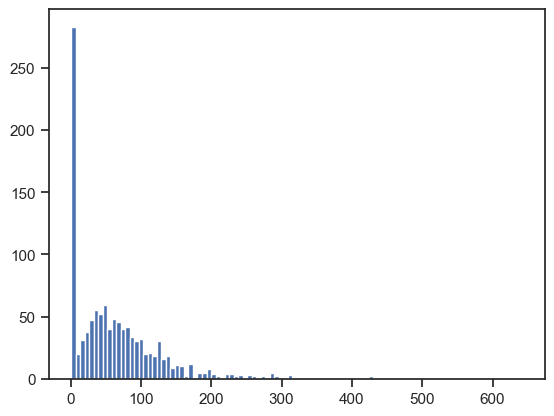

count    1131.000000
mean       70.122900
std        92.188466
min         2.000000
25%         7.000000
50%        44.000000
75%        94.000000
max      1113.000000
Name: reason_mental_len, dtype: float64

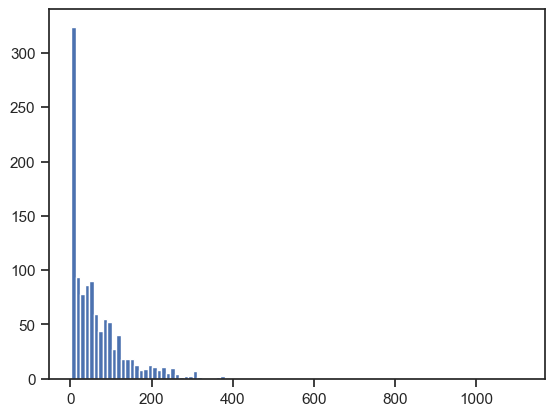

In [23]:
# add the length of the two answers as features to the dataset
reason_physical = df_v7['reason_willingness_physical_disclosure_interview']
reason_mental = df_v7['reason_willingness_mh_disclosure_interview']

df_v7['reason_physical_len'] = reason_physical.map(lambda text: len(str(text)))
df_v7['reason_mental_len'] = reason_mental.map(lambda text: len(str(text)))

display(df_v7['reason_physical_len'].describe())
plt.hist(df_v7['reason_physical_len'], bins=100)
plt.show()

display(df_v7['reason_mental_len'].describe())
plt.hist(df_v7['reason_mental_len'], bins=100)
plt.show()

Observations
* data is highly positively skewed (due to all the individuals who did not provide an answer)
* individuals provided longer reasons for bringing up mental health issues (M = 70.12, SD = 92.19) in a job interview than for bringing up physical health issues (M = 65.18, SD = 67.16) in a job interview, although the median points in the other direction (median-mental: 44, median-physical: 50)

## 3 Aggregating Categories

* the dataset contains many nominally scaled variables (among others, all variables are considered nominally scaled if they have a n/a response category)
* to be able to apply machine learning algorithms, nominally scaled variables have to be transformed into numeric variables, which is mostly done using one-hot encoding, thereby further increasing the number of features
* to reduce the high number of features and to increase the interpretability of the one-hot encoded features, categories are summarized 

In [24]:
df_v8 = df_v7.copy()

value counts of willingness_mh_disclosure_family :


,count,percent
Somewhat open,544,0.480990
Not applicable to me (I do not have a mental illness),324,0.286472
Somewhat not open,188,0.166225
Neutral,75,0.066313


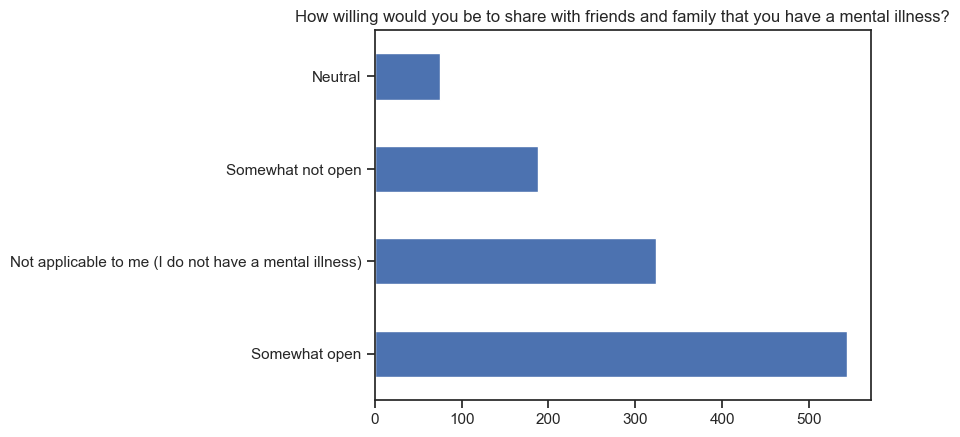

In [25]:
# for the willingness_mh_disclosure_family feature, summarize the categories "not open at all" and "somewhat not open" as well as the categories "very open" and "somewhat open"
df_v8.loc[df_v8['willingness_mh_disclosure_family'] == 'Not open at all', 'willingness_mh_disclosure_family'] = 'Somewhat not open'
df_v8.loc[df_v8['willingness_mh_disclosure_family'] == 'Very open', 'willingness_mh_disclosure_family'] = 'Somewhat open'
f.explore_feature(df_v8['willingness_mh_disclosure_family']) 

value counts of neg_effect_work_treated :


,count,percent
Not applicable to me,608,0.537577
Rarely,276,0.244032
Sometimes,247,0.218391


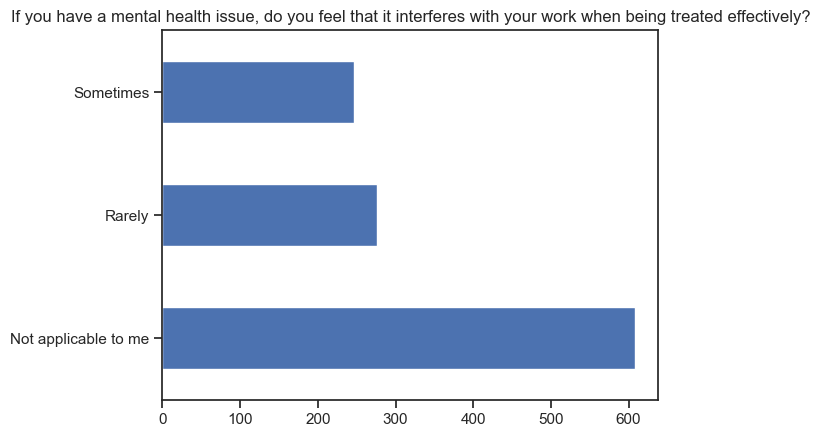

In [26]:
# for the feature neg_effect_work_treated, summarize "never" and "rarely" as well as "sometimes" and "often"
df_v8.loc[df_v8['neg_effect_work_treated'] == 'Never', 'neg_effect_work_treated'] = 'Rarely'
df_v8.loc[df_v8['neg_effect_work_treated'] == 'Often', 'neg_effect_work_treated'] = 'Sometimes'
f.explore_feature(df_v8['neg_effect_work_treated'])

value counts of neg_effect_work_not_treated :


,count,percent
Not applicable to me,538,0.475685
Often,370,0.327144
Sometimes,223,0.197171


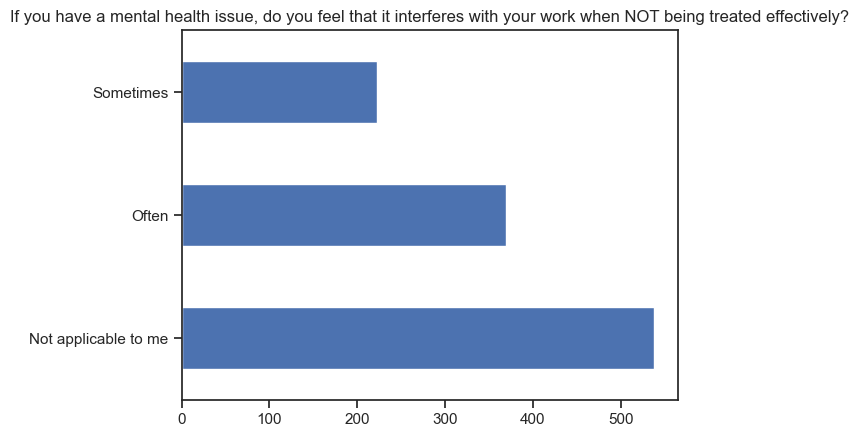

In [27]:
# for the feature neg_effect_work_not_treated, summarize "never", "rarely" and "sometimes" to be able to differentiate respondents best from each other, since here most respondents
# (more than 25% each) checked "sometimes" and "often" and less than 5% each selected "rarely" and "never"
df_v8.loc[df_v8['neg_effect_work_not_treated'] == 'Never', 'neg_effect_work_not_treated'] = 'Sometimes'
df_v8.loc[df_v8['neg_effect_work_not_treated'] == 'Rarely', 'neg_effect_work_not_treated'] = 'Sometimes'
f.explore_feature(df_v8['neg_effect_work_not_treated'])

value counts of diff_neg_effect_treated_vs_not_treated :


,count,percent
Not applicable to me,613,0.541998
positive effect of treatment,420,0.371353
no effect of treatment,98,0.086649


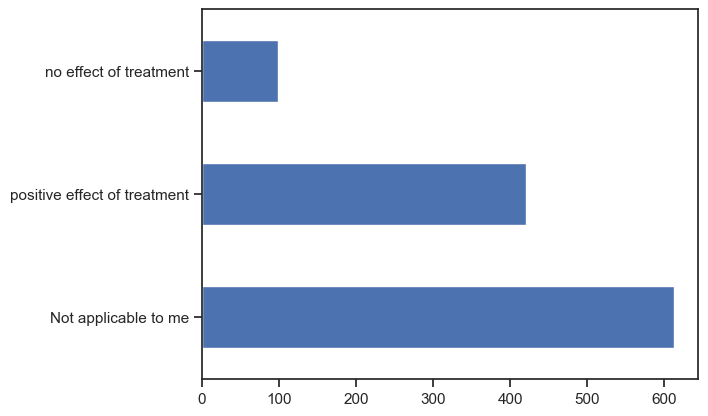

In [28]:
# for the feature diff_neg_effect_treated_vs_not_treated, combine "negative effect of treatment" with "no effect of treatment"
# because "negative effect of treatement" was chosen only by less than 1% of the respondents 
df_v8.loc[df_v8['diff_neg_effect_treated_vs_not_treated'] == 'negative effect of treatment', 'diff_neg_effect_treated_vs_not_treated'] = 'no effect of treatment'
f.explore_feature(df_v8['diff_neg_effect_treated_vs_not_treated'], original=False)

value counts of mh_disclosure_expected_neg_effect_career :


,count,percent
Yes,519,0.458886
Maybe,466,0.412025
No,146,0.129089


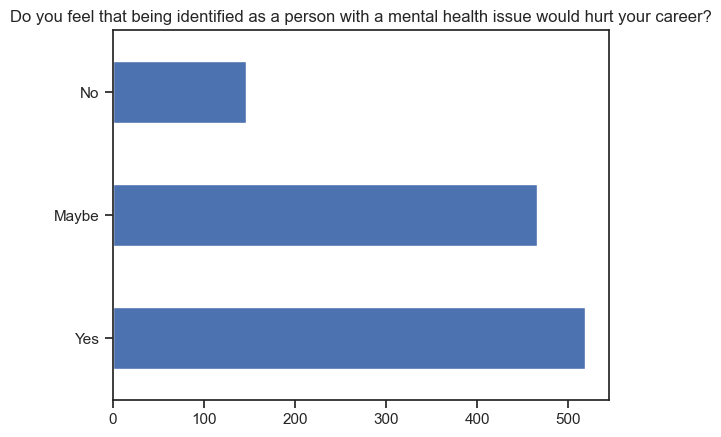

In [29]:
# for the feature mh_disclosure_expected_neg_effect_career, merge the two "no" and the two "yes" categories, because 
# the additional information contained is already covered by the mhd_disclosed variables (see section 4.1)
df_v8['mh_disclosure_expected_neg_effect_career'] = df_v8['mh_disclosure_expected_neg_effect_career'].replace(['No, I don\'t think it would', 'No, it has not', 'Yes, I think it would', 'Yes, it has'],
                                                                                                                ['No', 'No', 'Yes', 'Yes'])

f.explore_feature(df_v8['mh_disclosure_expected_neg_effect_career'])

value counts of mh_disclosure_expected_neg_view_coworkers :


,count,percent
Maybe,456,0.403183
No,346,0.305924
Yes,329,0.290893


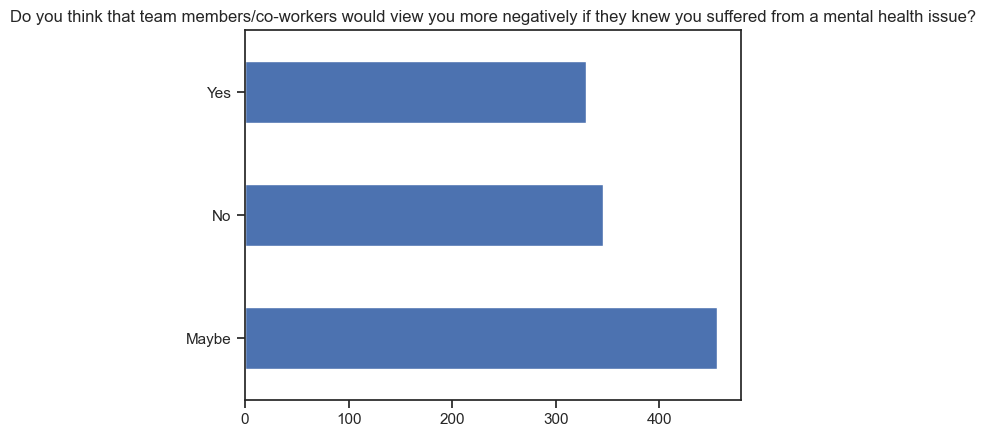

In [30]:
# for the feature mh_disclosure_expected_neg_view_coworkers, merge the two "no" and the two "yes" categories, because 
# the additional information contained is already covered by the mhd_disclosed variables (see section 4.1)
df_v8['mh_disclosure_expected_neg_view_coworkers'] = df_v8['mh_disclosure_expected_neg_view_coworkers'].replace(['No, I don\'t think they would', 'No, they do not', 
                                                                                                                 'Yes, I think they would', 'Yes, they do'], ['No', 'No', 'Yes', 'Yes'])

f.explore_feature(df_v8['mh_disclosure_expected_neg_view_coworkers'])

value counts of mh_neg_effect_workplace_observed :


,count,percent
No,488,0.431477
Yes,320,0.282935
Maybe/Not sure,272,0.240495
NaN,51,0.045093


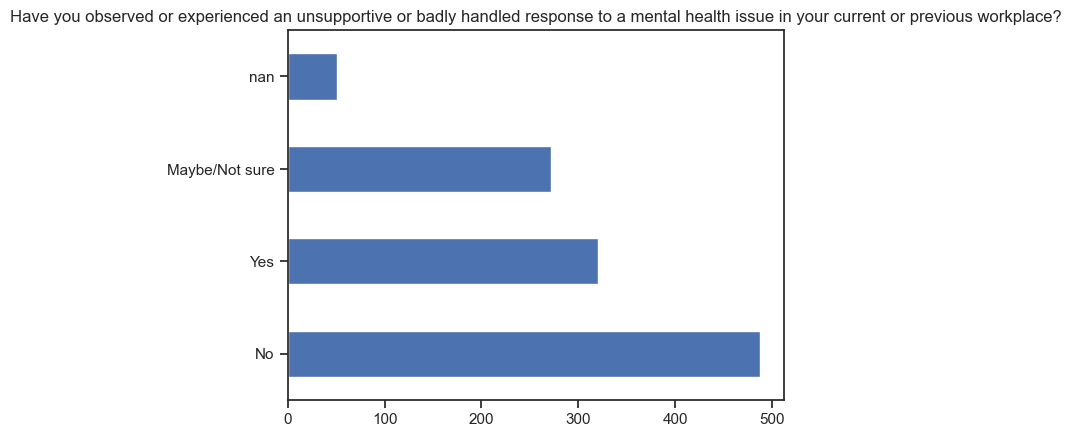

In [31]:
# for the feature mh_disclosure_expected_neg_view_coworkers, merge the two "yes" categories, because 
# the additional information contained is already covered by the mhd_disclosed variables (see section 4.1)
df_v8['mh_neg_effect_workplace_observed'] = df_v8['mh_neg_effect_workplace_observed'].replace(['Yes, I experienced', 'Yes, I observed'], ['Yes', 'Yes'])

f.explore_feature(df_v8['mh_neg_effect_workplace_observed'])

## 4 Treating "Don't Know" Responses as Scale Midpoints 

* "don't know" responses are recoded as scale means where applicable 
* this method showed no disadvantages compared to more sophisticated methods of handling "don't know" responses (Denman et al., 2018, p. 680) and has the advantage that such variables can be treated as ordinal

value counts of difficulty_asking_for_leave :


,count,percent
Neither easy nor difficult,325,0.287356
Somewhat easy,279,0.246684
Very easy,219,0.193634
Somewhat difficult,192,0.169761
Very difficult,116,0.102564


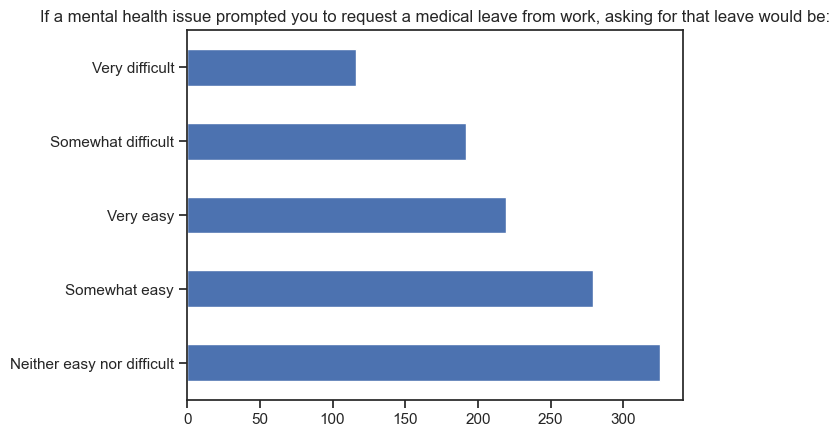

In [32]:
df_v8.loc[df_v8['difficulty_asking_for_leave'] == 'I don\'t know', 'difficulty_asking_for_leave'] = 'Neither easy nor difficult'
f.explore_feature(df_v8['difficulty_asking_for_leave'])

## 5 Handling Inconsistent Data

* consider how many data records were coded as inconsistent and how often they were coded as inconsistent
* all respondents with inconsistent data are excluded, because an inconsistency indicates at least one incorrect statement and it cannot be determined which statement was incorrect
* inconsistent data records may result, for example, from respondents skimming the questions and completing them only to receive a possible reward for participation

In [33]:
df_v9 = df_v8.copy()

value counts of times_inconsistent :


,count,percent
0,880,0.778073
1,117,0.103448
2,68,0.060124
3,35,0.030946
4,29,0.025641
5,2,0.001768


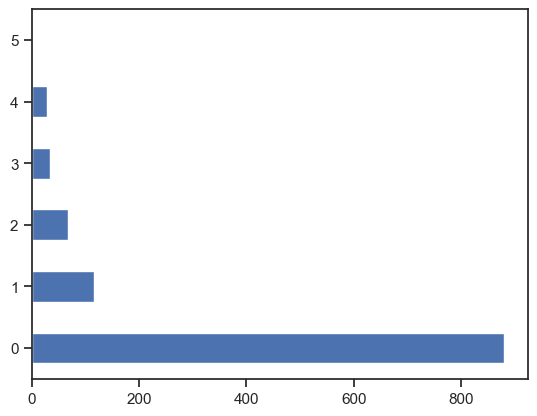

In [34]:
# check how many data records were coded as inconsistent and how often they were coded as inconsistent 
f.explore_feature(df_v9['times_inconsistent'], original=False)

Observations
* 22% of the respondents were coded as inconsistent at least once
* 10% of the respondents showed only one inconsistency

value counts of reason_inconsistent :


,count,percent
not treated but indicated whether their mhd has a negative effect on work when treated effectively,44,0.376068
only maybe ill at any time but indicated whether their mhd has a negative effect on work when not treated,32,0.273504
only maybe ill but indicated that they were treated,16,0.136752
not ill but indicated that they were treated,9,0.076923
did not indicate an mhd but disclosed an mhd,5,0.042735
currently ill without current diagnoses indicated,5,0.042735
only maybe ill at any time but indicated whether their mhd has a negative effect on work when treated effectively,2,0.017094
maybe currently ill without possible diagnoses indicated,2,0.017094
diagnosed by professional but no professional diagnoses,1,0.008547
not ill at any time but indicated whether their mhd has a negative effect on work when treated effectively,1,0.008547


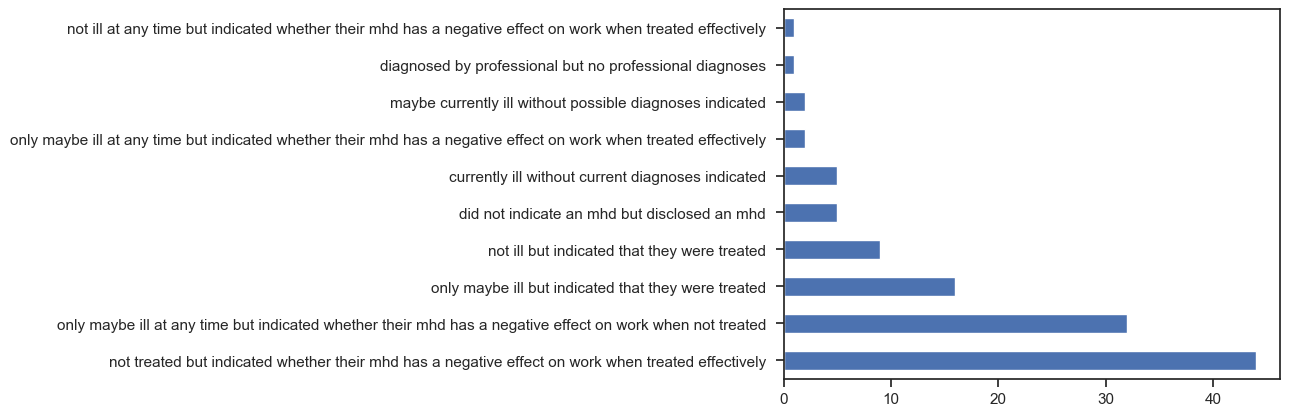

In [35]:
# create a dataset containing only the inconsistent data where individuals gave at least one inconsistent answer
df_inconsistent = df_v9.loc[df_v9['times_inconsistent'] > 0][['times_inconsistent', 'reason_inconsistent']].copy()

# delete the last "|" separator
df_inconsistent['reason_inconsistent'] = df_inconsistent['reason_inconsistent'].str.rstrip('|')

df_once_inconsistent = df_inconsistent[df_inconsistent['times_inconsistent'] == 1].copy()
f.explore_feature(df_once_inconsistent['reason_inconsistent'], original=False)

Observations
* the most common reason (38%) for a single inconsistency in the dataset is that individuals have indicated the extent to which the mental disorder negatively affects work when it is effectively treated 
* the second most common (27%) reason for a single inconsistency is that individuals say they are only "maybe" mentally disordered, and yet give an answer to the question about the negative effect of their mental disorder on work when it is not effectively treated 

Inconsistencies:
value counts of reason_inconsistent :


,count,percent
only maybe ill at any time but indicated whether their mhd has a negative effect on work when not treated,135,0.278926
only maybe ill at any time but indicated whether their mhd has a negative effect on work when treated effectively,87,0.179752
only maybe ill but indicated that they were treated,74,0.152893
not treated but indicated whether their mhd has a negative effect on work when treated effectively,45,0.092975
"professional diagnoses indicated but only ""maybe"" ill",30,0.061983
not ill at any time but indicated whether their mhd has a negative effect on work when treated effectively,28,0.057851
did not indicate an mhd but disclosed an mhd,25,0.051653
not ill at any time but indicated whether their mhd has a negative effect on work when not treated,25,0.051653
not ill but indicated that they were treated,21,0.043388
currently ill without current diagnoses indicated,6,0.012397


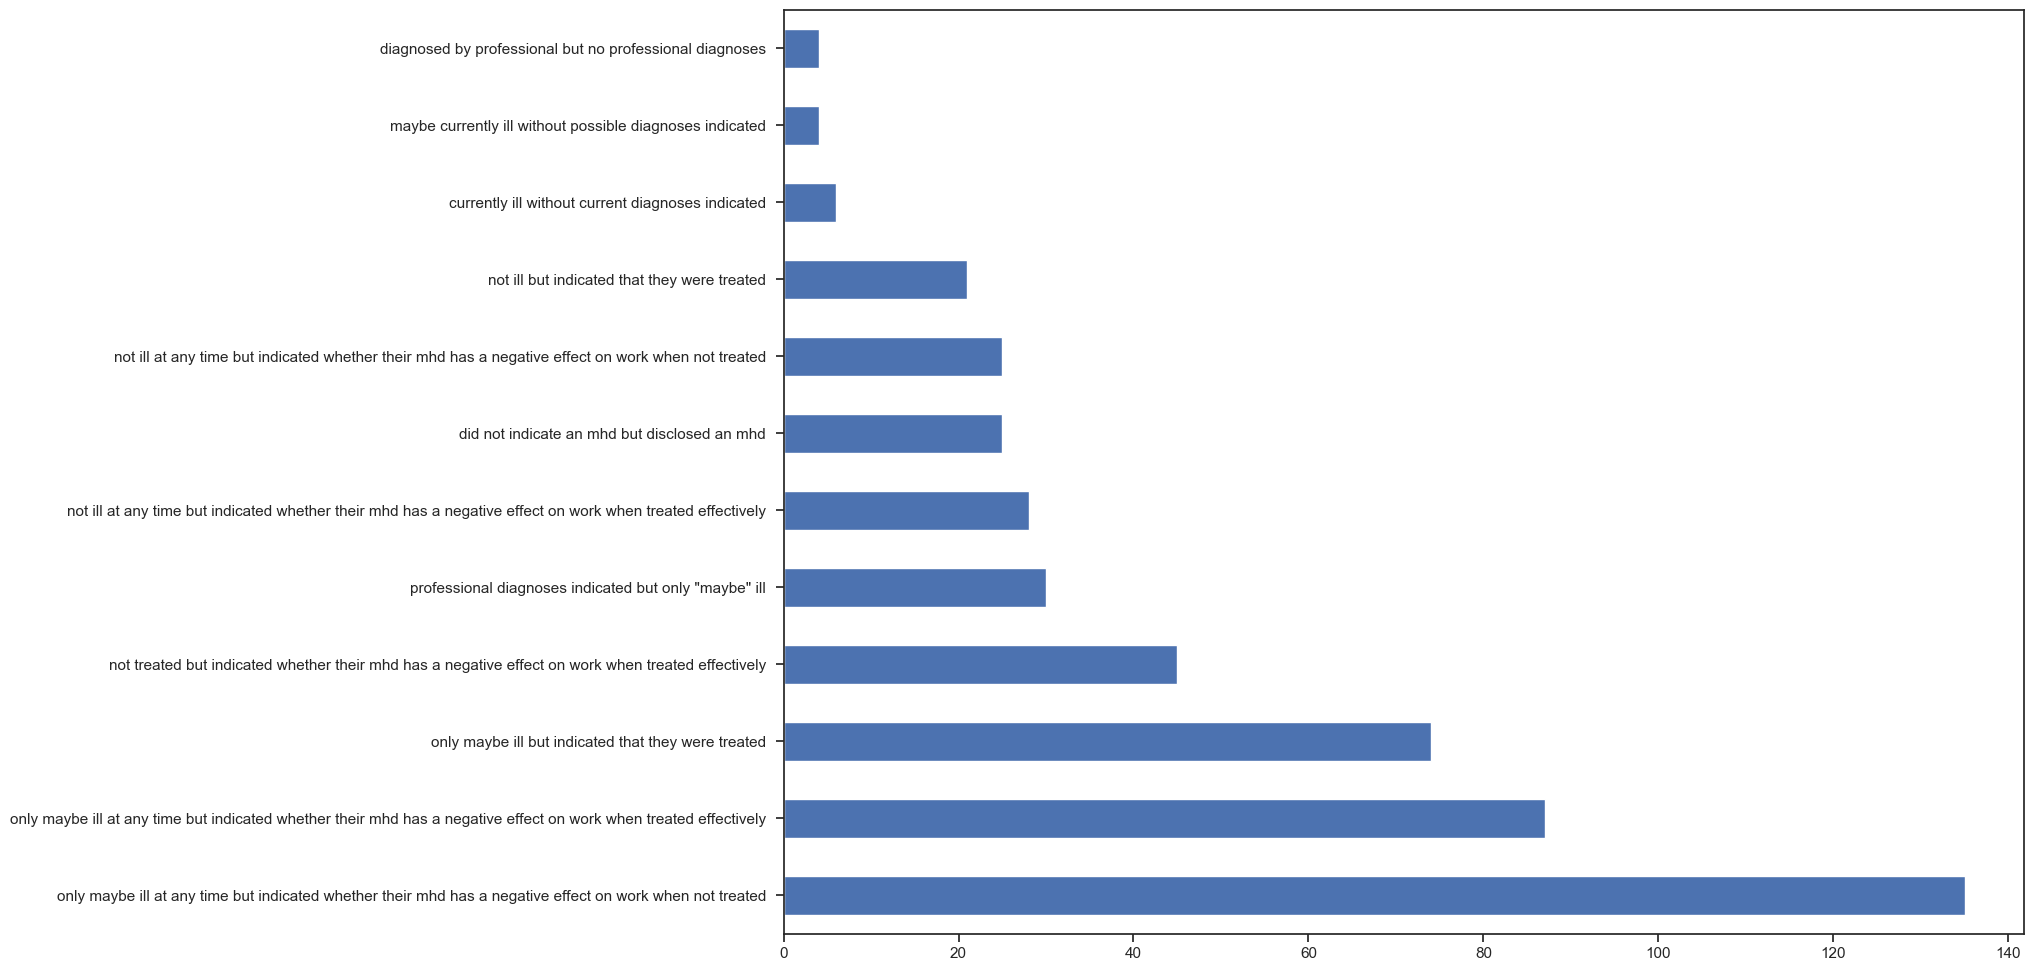

In [36]:
# delete the last "|" separator to prevent empty lines in the output below
df_inconsistent['reason_inconsistent'] = df_inconsistent['reason_inconsistent'].str.rstrip('|')

# show how many times each inconsistency was detected
print("Inconsistencies:")
f.n_per_option(df_inconsistent, 'reason_inconsistent')

Observations
* the most common reason (28%) for an inconsistency is that individuals say they are only "maybe" mentally disordered, and yet give an answer to the question about the negative effect of their mental disorder on work when it is not effectively treated
* the second most common (18%) reason for an inconsistency is that individuals say they are only "maybe" mentally disordered, and yet give an answer to the question about the negative effect of their mental disorder on work when it is effectively treated

In [37]:
# exclude inconsistent data from further analysis, as well as the columns "times_inconsistent" and "reason_inconsistent", since they are no longer needed
df_v10 = df_v9.drop(index=df_inconsistent.index, columns=['times_inconsistent', 'reason_inconsistent'])
print('shape before exclusion:', df_v9.shape)
print('shape after exclusion:', df_v10.shape)

# reset the maximum column width of pandas data frames to the default value
pd.reset_option('display.max_colwidth') 

shape before exclusion: (1131, 159)
shape after exclusion: (880, 157)


## 6 Handling Missing Values

* display descriptive statistics for missing values
* display the variables with missing values
* exclude all variables with at least 5% missing values to avoid reducing the sample further
* exclude all individuals with missing values in the remaining variables 

In [38]:
# display descriptive statistics for missing values
f.missing_statistics(df_v10)

Number of variables with missing values:
30

Descriptive statistics of percent missing values per column:
count    157.000000
mean       0.070722
std        0.231933
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: missing_percent, dtype: float64

Descriptive statistics of missing values per row:


count    880.000000
mean      11.103409
std        3.700935
min        8.000000
25%        9.000000
50%       10.000000
75%       11.000000
max       24.000000
dtype: float64

Observations
* there are 30 variables with missing values
* on average, 1% of values are missing per variable (SD = 0.23, median = 0)
* on average, each person has 11 missing values (SD = 3.70, median = 10) with a minimum of eight and a maximum of 24 missing values
* the fact that each person has at least eight missing values is due to the variables that were answered only by the excluded self-employed respondents

In [39]:
# create a data dictionary for the current dataset
data_dict_v3 = f.create_data_dict(df_v10)

# display only variables with missing values
def display_var_with_missings(data_dict):
    """filter the data dictionary for variables with missing values and display them  
    
    :param data_dict: the data dictionary for which variables with missing values are to be returned ('pandas.core.frame.DataFrame')
    :return: a data frame of the variables with missing values ('pandas.core.frame.DataFrame')
    """
    
    return data_dict.loc[data_dict['missing_count'] > 0].copy()

df_var_with_missings = display_var_with_missings(data_dict_v3)
df_var_with_missings

,variable,unique_values,uniques_count,data_types,missing_count,missing_percent,dk_count,dk_percent,n/a_count,n/a_percent
3,tech_role,"[nan, 1.0]",2,nominal,690,0.784091,0,0.000000,0,0.000000
5,employer_mh_options_known,"[N/A because no employer provided coverage, Ye...",5,nominal,5,0.005682,0,0.000000,220,0.250000
16,mh_treatment_coverage,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000
17,local_resources_mh_known,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000
18,mh_disclosure_clients,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000
19,mh_disclosure_clients_neg_impact,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000
20,mh_disclosure_coworker,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000
21,mh_disclosure_coworker_neg_impact,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000
22,mh_effect_on_productivity,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000
23,mh_effect_on_productivity_percent,[nan],1,nominal,880,1.000000,0,0.000000,0,0.000000


Observations
* as expected, eight variables consist exclusively of missing values
* 11 variables have exactly 97 missing values (11%), these variables all relate to previous employers. These variables are most likely not that meaningful anyway, because individuals probably think of one employer for one question and another employer for another question, and this is further influenced by the number of previous employers
* for the two text features containing reasons for answers, more than 20% of the values are missing
* for seven variables, less than 5% of the values are missing

In [40]:
# exclude all variables with at least 5% missing values
high_pct_missings_vars = data_dict_v3.loc[data_dict_v3['missing_percent'] >= 0.05, 'variable'].to_list()
df_v11 = df_v10.drop(columns=high_pct_missings_vars).copy()
print('shape before variable exclusion:', df_v10.shape)
print('shape after variable exclusion:', df_v11.shape)

shape before variable exclusion: (880, 157)
shape after variable exclusion: (880, 134)


In [41]:
# exclude all individuals with missing values in the remaining variables
df_final = df_v11.dropna().copy()
print('shape before variable exclusion:', df_v11.shape)
print('shape after variable exclusion:', df_final.shape)

shape before variable exclusion: (880, 134)
shape after variable exclusion: (829, 134)


In [42]:
# save this final dataset as csv for possible later use 
df_final.to_csv('df_final.csv', encoding='utf-8', index=False)

## 7 Exploring the Final Dataset (Before Feature Encoding and Selection)

* perform some descriptive analyses to understand the final sample and relationships among variables 

### 7.1 Demographic Variables

* examine demographic characteristics (age, gender, company size) of the final sample 

descriptive statistics of participant's ages:


count    829.000000
mean      33.472859
std        7.711169
min       19.000000
25%       28.000000
50%       32.000000
75%       38.000000
max       70.000000
Name: age, dtype: float64

value counts of gender :


,count,percent
male,602,0.726176
female,202,0.243667
other,25,0.030157


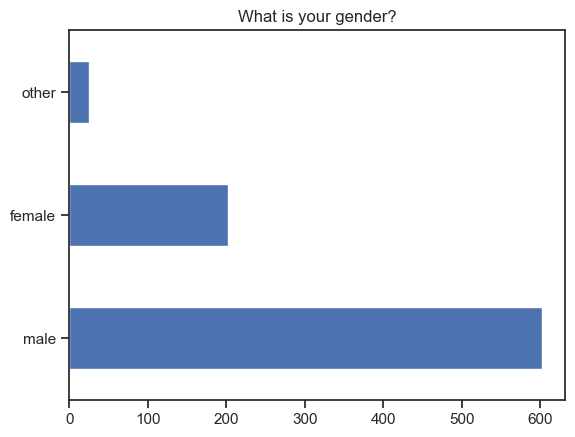

value counts of N_employees :


,count,percent
26-100,221,0.266586
More than 1000,191,0.230398
100-500,173,0.208685
6-25,149,0.179735
500-1000,57,0.068758
1-5,38,0.045838


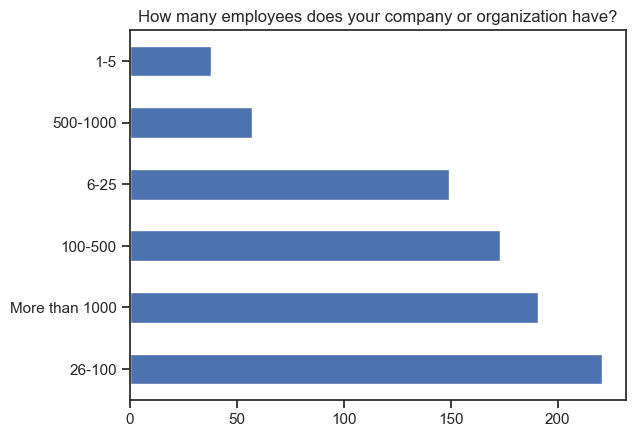

In [43]:
# examine participant's age, gender and company size
# age
print('descriptive statistics of participant\'s ages:')
display(df_final['age'].describe())

# gender
f.explore_feature(df_final['gender'])

# company size
f.explore_feature(df_final['N_employees'])

Observations
* respondents are on average 33 years old (SD = 7.7, median = 32)
* most respondents are male (73%), followed by female (24%)
* respondents mostly work in companies with 26-100 employees (27%), followed by companies with more than 1000 employees (23%)

### 7.2 Explore Associations Between Variables

* consider the association between selected variables (due to the large number of features, only selected associations where an association of both features seems plausible are considered)
* use Kendall's Tau to look at the association of two at least ordinally scaled variables, because it has shown advantages in comparison to other correlation measures (Gilpin, 1993, p. 88)

In [44]:
def calculate_kendall_tau(col1, col2, data, scale_first=True, scale_second=True):
    """calculate and display Kendall's tau including its significance for two variables
    
    :param col1: the name of the first variable ('str')
    :param col2: the name of the second variable ('str')
    :param data: the data source (pandas.core.frame.DataFrame)
    :param scale_first: whether the first variable needs to be encoded numerically ('bool')
    :param scale_second: whether the second variable needs to be encoded numerically ('bool')
    """    
    
    # code variables numerically if required
    if scale_first:
        # "No", "Maybe", "Yes" is the most common scale for ordinal variables in the dataset
        scale1 = {'No': 0, 'Maybe': 1, 'Yes': 2, 'Maybe/Not sure': 1, 'I don\'t know': 1}
    if scale_second:
        scale2 = {'No': 0, 'Maybe': 1, 'Yes': 2, 'Maybe/Not sure': 1, 'I don\'t know': 1}
    col1_encoded = data[col1].replace(scale1) if scale_first else data[col1]
    col2_encoded = data[col2].replace(scale2) if scale_second else data[col2]
    df_cols = pd.concat([col1_encoded, col2_encoded], axis=1)
    
    # calculate Kendall's tau and its significance
    coef, p = kendalltau(df_cols[col1], df_cols[col2])
    print('Kendall\'s tau b rank correlation coefficient:', coef)
    print('p-value of the Kendall\'s tau b rank correlation coefficient:', p)

#### 7.2.1 Gender and ...

* due to the small number of individuals in the gender category "other", the following analyses are interpreted only with regard to the differences between women and men 

absolute values:


mh_disclosure_coworker_comfortable,Maybe,No,Yes
gender,,,
female,82,70,50
male,264,193,145
other,9,9,7


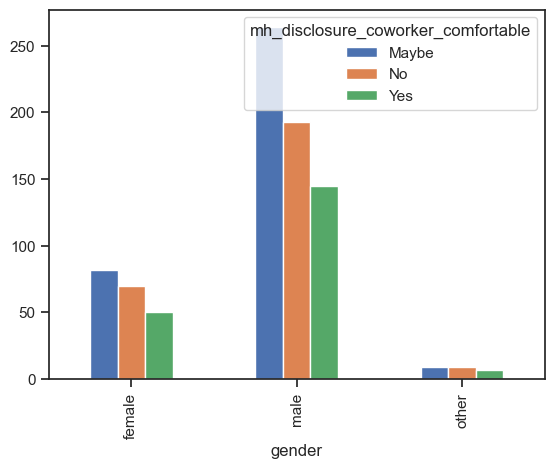

------------------------------------------
relative values:


mh_disclosure_coworker_comfortable,Maybe,No,Yes
gender,,,
female,0.405941,0.346535,0.247525
male,0.438538,0.320598,0.240864
other,0.360000,0.360000,0.280000


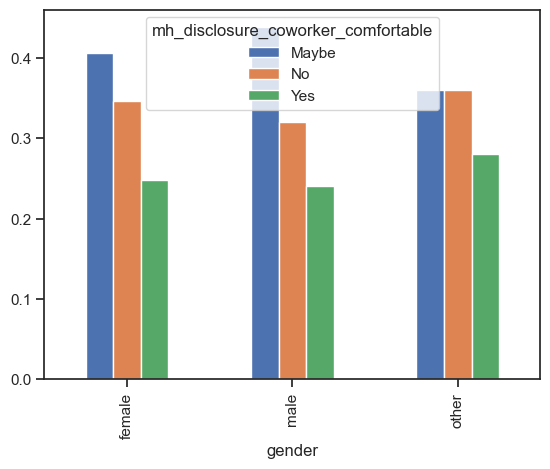

In [45]:
# feeling comfortable discussing mental health issues with coworkers 
f.show_pivot_tables_and_bars('gender', 'mh_disclosure_coworker_comfortable', df_final)

Observations
* men and women show approximately the same response tendencies in terms of feeling comfortable sharing mental health problems with coworkers 

absolute values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
gender,,,
female,68,56,78
male,201,168,233
other,9,8,8


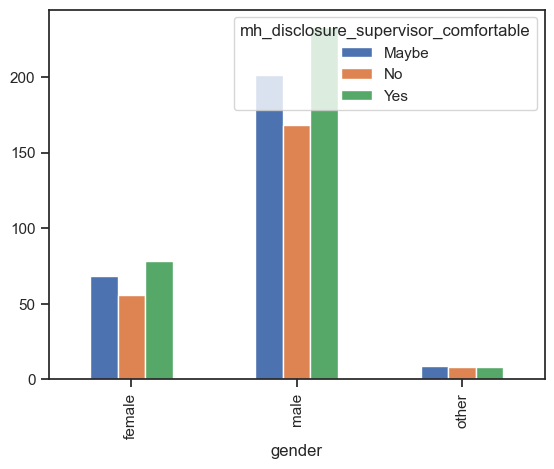

------------------------------------------
relative values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
gender,,,
female,0.336634,0.277228,0.386139
male,0.333887,0.279070,0.387043
other,0.360000,0.320000,0.320000


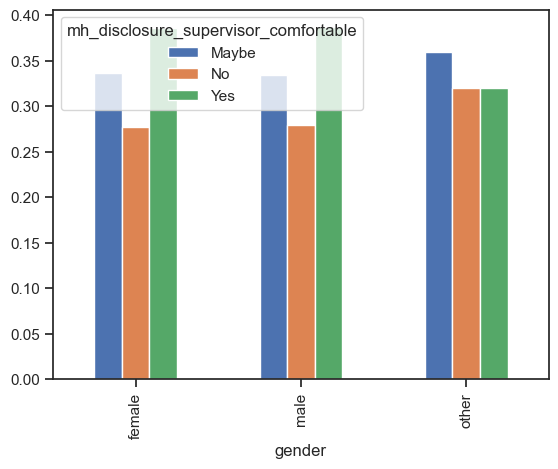

In [46]:
# feeling comfortable discussing mental health issues with supervisors 
f.show_pivot_tables_and_bars('gender', 'mh_disclosure_supervisor_comfortable', df_final)

Observations
* men and women show approximately the same response tendencies in terms of feeling comfortable sharing mental health problems with supervisors 

absolute values:


"(1) Mood Disorder (Depression, Bipolar Disorder, etc)",0.0,1.0
gender,,
female,96,106
male,424,178
other,10,15


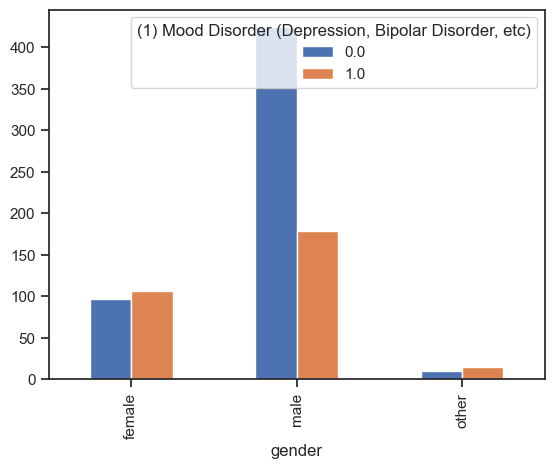

------------------------------------------
relative values:


"(1) Mood Disorder (Depression, Bipolar Disorder, etc)",0.0,1.0
gender,,
female,0.475248,0.524752
male,0.704319,0.295681
other,0.400000,0.600000


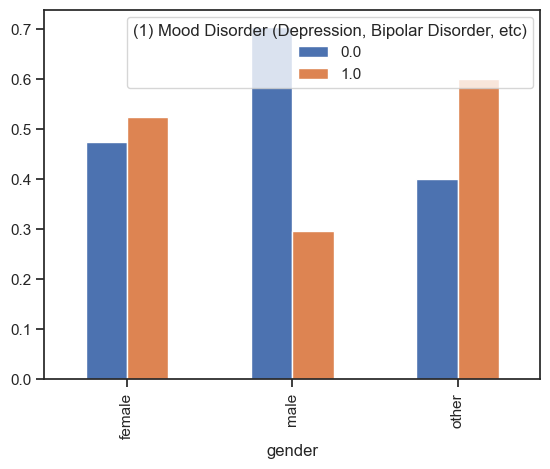

In [47]:
# mood disorder 
f.show_pivot_tables_and_bars('gender', '(1) Mood Disorder (Depression, Bipolar Disorder, etc)', df_final) 

Observations
* 52% of women, but only 30% of men, currently suffer from mood disorder

absolute values:


(1) Attention Deficit Hyperactivity Disorder,0.0,1.0
gender,,
female,175,27
male,547,55
other,23,2


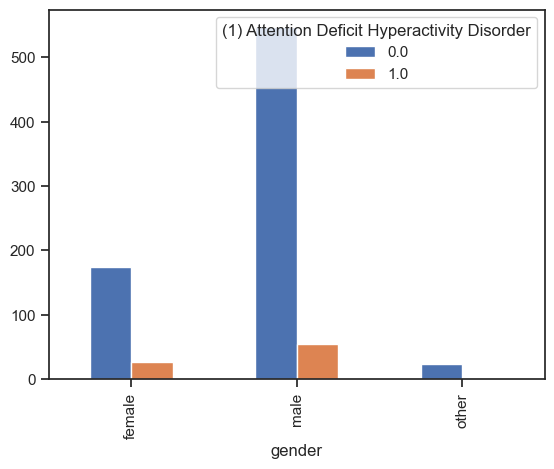

------------------------------------------
relative values:


(1) Attention Deficit Hyperactivity Disorder,0.0,1.0
gender,,
female,0.866337,0.133663
male,0.908638,0.091362
other,0.920000,0.080000


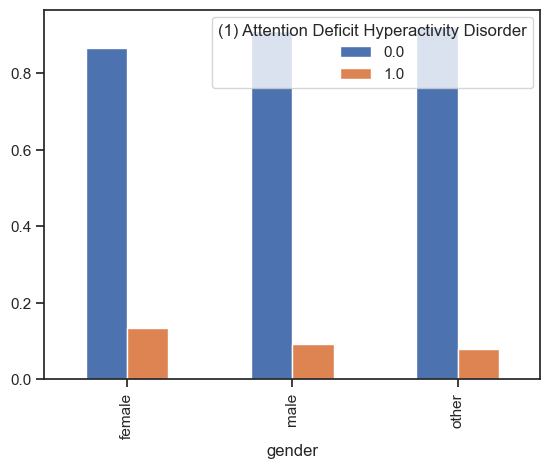

In [48]:
# attention deficit hyperactivity disorder (ADHD)
f.show_pivot_tables_and_bars('gender', '(1) Attention Deficit Hyperactivity Disorder', df_final)

Observations
* slightly more women (13%) than men (9%) suffer from ADHD

absolute values:


"(1) Anxiety Disorder (Generalized, Social, Phobia, etc)",0.0,1.0
gender,,
female,119,83
male,456,146
other,12,13


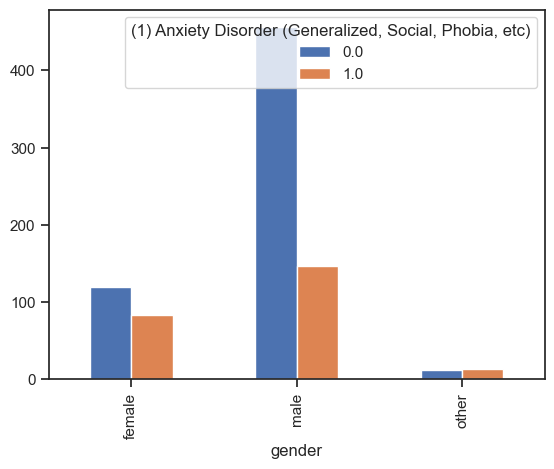

------------------------------------------
relative values:


"(1) Anxiety Disorder (Generalized, Social, Phobia, etc)",0.0,1.0
gender,,
female,0.589109,0.410891
male,0.757475,0.242525
other,0.480000,0.520000


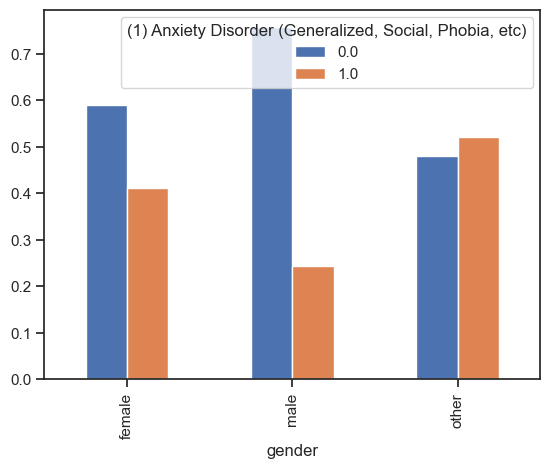

In [49]:
# anxiety
f.show_pivot_tables_and_bars('gender', '(1) Anxiety Disorder (Generalized, Social, Phobia, etc)', df_final)

Observations
* considerably more women (41%) than men (24%) suffer from anxiety disorder

absolute values:


mhd_anytime,Maybe,No,Yes
gender,,,
female,6.0,38.0,158.0
male,34.0,202.0,366.0
other,1.0,NaN,24.0


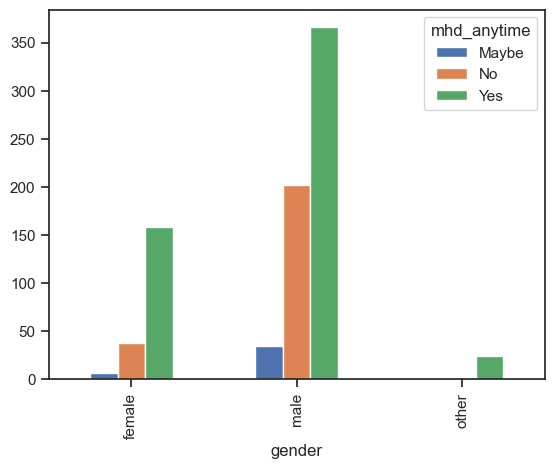

------------------------------------------
relative values:


mhd_anytime,Maybe,No,Yes
gender,,,
female,0.029703,0.188119,0.782178
male,0.056478,0.335548,0.607973
other,0.040000,NaN,0.960000


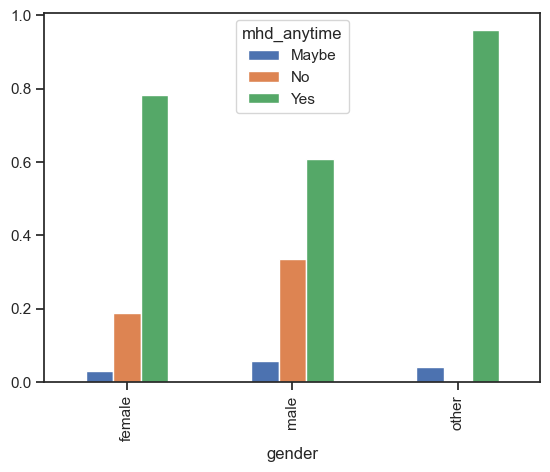

In [50]:
# having had a mental health disorder at some point in time
f.show_pivot_tables_and_bars('gender', 'mhd_anytime', df_final)

Observations
* women (78%) more often reported having (had) a mental disorder than men (61%)
* men (34%) more often reported not having (had) a mental disorder than women (19%)

#### 7.2.2 Feeling Comfortable to Share With Direct Supervisors and...

absolute values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
employer_mh_benefits,,,
I don't know,75,63,73
No,47,54,45
Not eligible for coverage / N/A,24,14,22
Yes,132,101,179


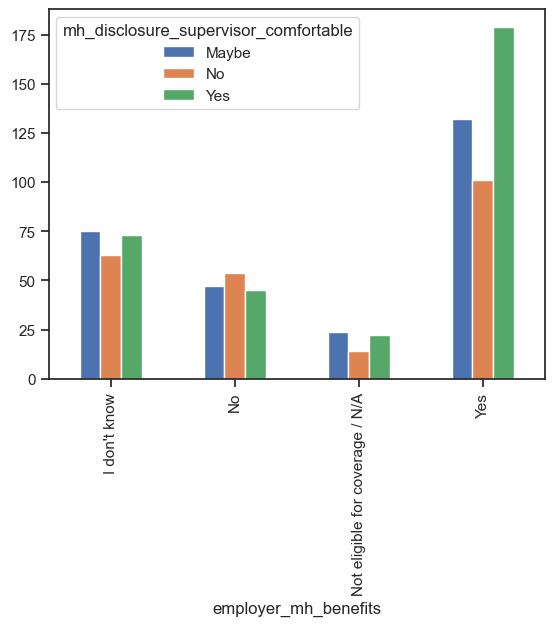

------------------------------------------
relative values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
employer_mh_benefits,,,
I don't know,0.355450,0.298578,0.345972
No,0.321918,0.369863,0.308219
Not eligible for coverage / N/A,0.400000,0.233333,0.366667
Yes,0.320388,0.245146,0.434466


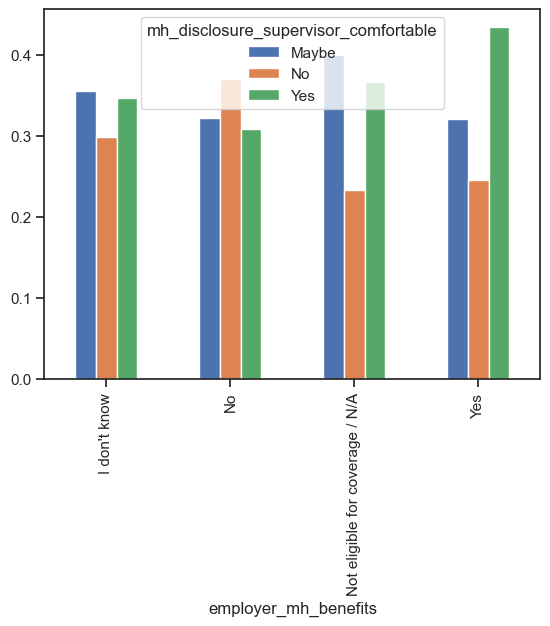

In [51]:
# whether the employer provides mental health care benefits 
f.show_pivot_tables_and_bars('employer_mh_benefits', 'mh_disclosure_supervisor_comfortable', df_final)

Observations
* individuals whose employer provides mental health benefits are more likely (43%) to feel comfortable sharing their issues with their supervisors than individuals whose employer does not provide mental health benefits (31%)
* individuals whose employer does not provide mental health benefits are less likely (37%) to feel comfortable sharing their issues with their supervisors than individuals, whose employer provides mental health benefits (25%)

absolute values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
willingness_mh_disclosure_family,,,
Neutral,13,22,13
Not applicable to me (I do not have a mental illness),88,60,102
Somewhat not open,34,50,25
Somewhat open,143,100,179


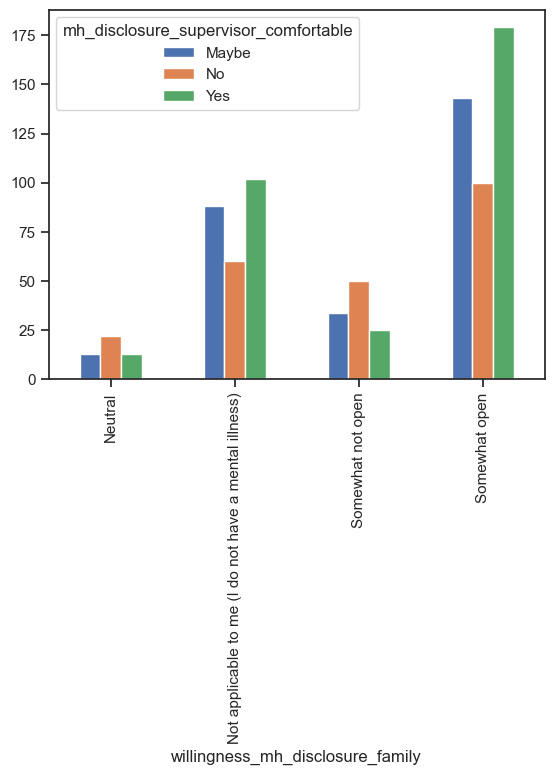

------------------------------------------
relative values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
willingness_mh_disclosure_family,,,
Neutral,0.270833,0.458333,0.270833
Not applicable to me (I do not have a mental illness),0.352000,0.240000,0.408000
Somewhat not open,0.311927,0.458716,0.229358
Somewhat open,0.338863,0.236967,0.424171


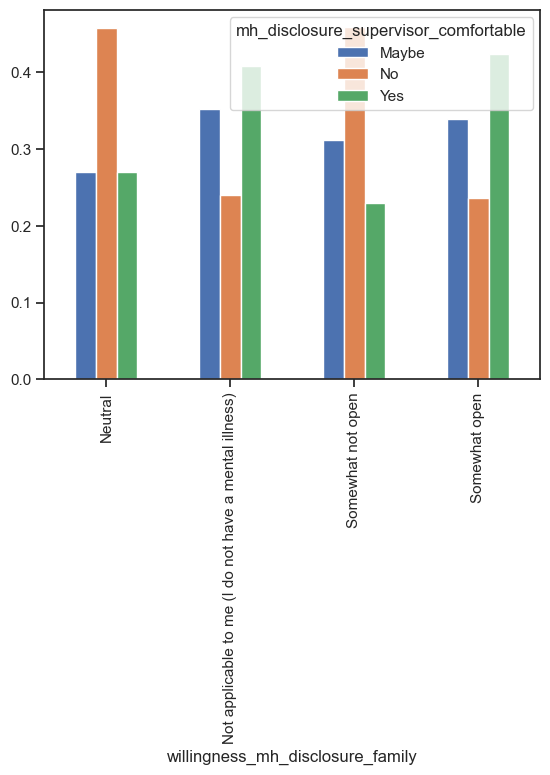

In [52]:
# feeling comfortable to share with family
f.show_pivot_tables_and_bars('willingness_mh_disclosure_family', 'mh_disclosure_supervisor_comfortable', df_final)

Observations
* individuals who are more likely to be open with their family (43%) would also be more comfortable opening up to their supervisor than individuals who are more likely not to be open with their family (20%)
* individuals who are not open with their family (47%) would be more likely to not feel comfortable opening up to their supervisor than individuals who are more likely to be open with their family (23%)

In [53]:
# whether the employer has formally discussed mental health care
calculate_kendall_tau('employer_mh_formally_discussed', 'mh_disclosure_supervisor_comfortable', df_final)

Kendall's tau b rank correlation coefficient: 0.2071702204541065
p-value of the Kendall's tau b rank correlation coefficient: 7.609551516998343e-11


Observations
* both variables correlate significantly positive with each other
* the more confident individuals are that their employer has discussed mental health with them, the more likely they are to open up to their supervisors 

#### 7.2.3 The Employer Providing Mental Health Benefits and...

absolute values:


employer_mh_benefits,I don't know,No,Not eligible for coverage / N/A,Yes
N_employees,,,,
1-5,4,19,9,6
100-500,46,21,8,98
26-100,68,33,10,110
500-1000,19,7,3,28
6-25,39,47,16,47
More than 1000,35,19,14,123


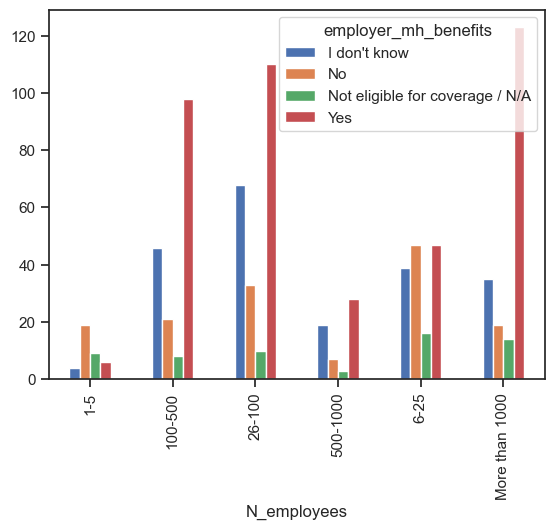

------------------------------------------
relative values:


employer_mh_benefits,I don't know,No,Not eligible for coverage / N/A,Yes
N_employees,,,,
1-5,0.105263,0.500000,0.236842,0.157895
100-500,0.265896,0.121387,0.046243,0.566474
26-100,0.307692,0.149321,0.045249,0.497738
500-1000,0.333333,0.122807,0.052632,0.491228
6-25,0.261745,0.315436,0.107383,0.315436
More than 1000,0.183246,0.099476,0.073298,0.643979


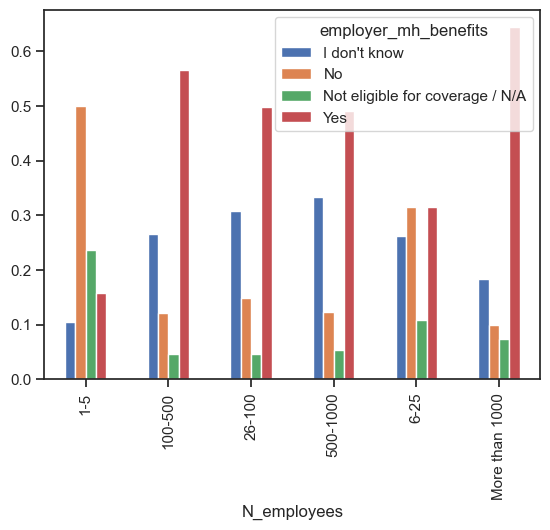

In [54]:
# the number of employees in the organization
f.show_pivot_tables_and_bars('N_employees', 'employer_mh_benefits', df_final)

Observations
* smaller companies are less likely to offer mental health benefits than larger companies: e.g., 64% of employees in companies with more than 1000 employees say that their employer provides mental health benefits, as compared to 16% of employees in companies with 1-5 employees and 32% of employees in companies with 26-100 employees

#### 7.2.4 Knowledge About Mental Health Care Options and ...

absolute values:


employer_mh_options_known,I am not sure,N/A because no employer provided coverage,No,Yes
employer_mh_formally_discussed,,,,
I don't know,28,9,18,23
No,147,165,139,140
Yes,44,32,22,62


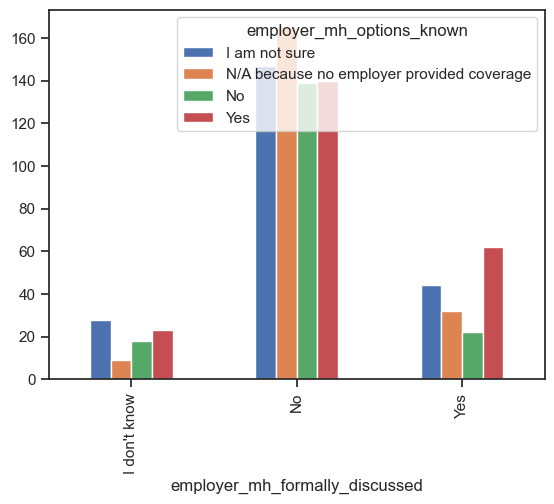

------------------------------------------
relative values:


employer_mh_options_known,I am not sure,N/A because no employer provided coverage,No,Yes
employer_mh_formally_discussed,,,,
I don't know,0.358974,0.115385,0.230769,0.294872
No,0.248731,0.279188,0.235195,0.236887
Yes,0.275000,0.200000,0.137500,0.387500


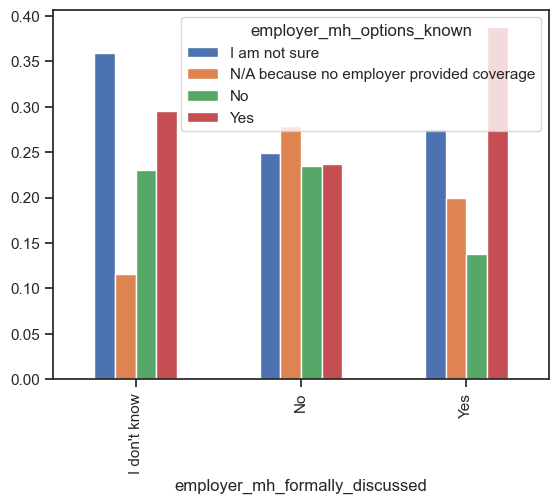

In [55]:
# whether the employer has formally discussed mental health care
f.show_pivot_tables_and_bars('employer_mh_formally_discussed', 'employer_mh_options_known', df_final)

Observations
* formal discussions about mental health are accompanied by greater knowledge among workers about the options available to them in this area: 
    * when the employer did not formally discuss mental health, 24% of employees reported knowing about available options, compared to 39% when the employer formally discussed mental health
    * when the employer has formally discussed mental health, the number of employees not knowing about their options (22) is lower than the number of employees knowing about their options (62)

absolute values:


employer_mh_options_known,I am not sure,N/A because no employer provided coverage,No,Yes
mhd_anytime,,,,
Maybe,15,9,11,6
No,67,66,75,32
Yes,137,131,93,187


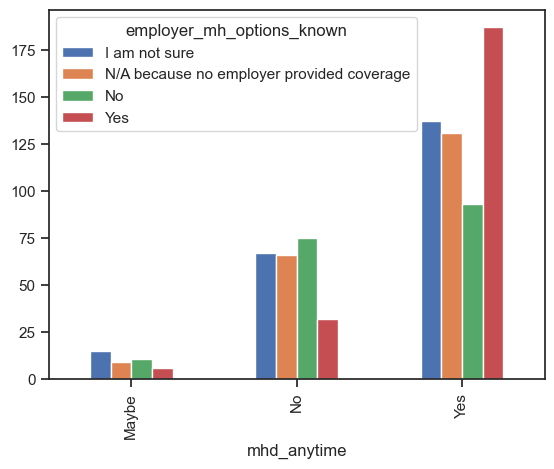

------------------------------------------
relative values:


employer_mh_options_known,I am not sure,N/A because no employer provided coverage,No,Yes
mhd_anytime,,,,
Maybe,0.365854,0.219512,0.268293,0.146341
No,0.279167,0.275000,0.312500,0.133333
Yes,0.250000,0.239051,0.169708,0.341241


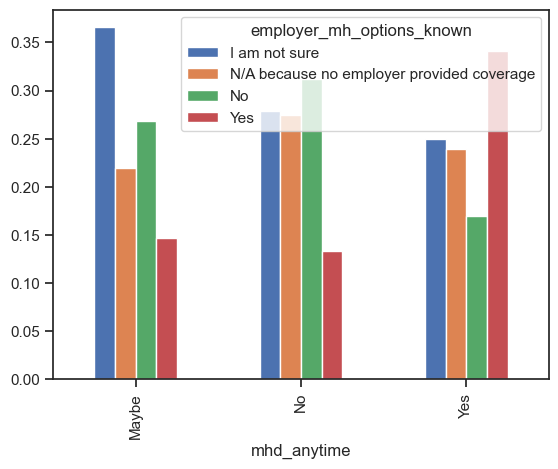

In [56]:
# whether the employee has or had a mental health issue
f.show_pivot_tables_and_bars('mhd_anytime', 'employer_mh_options_known', df_final)

Observations
* the proportion of individuals knowing about the mental health options provided by their employer is higher among individuals with mental health problems (34%) than among individuals without mental health problems (14%) (this could be due to personal relevance)
* however, 17% of individuals with mental health disorders do not know about the options provided by their employer 

absolute values:


employer_mh_options_known,I am not sure,N/A because no employer provided coverage,No,Yes
N_employees,,,,
1-5,2,28,4,4
100-500,52,29,35,57
26-100,62,43,59,57
500-1000,12,10,17,18
6-25,35,63,27,24
More than 1000,56,33,37,65


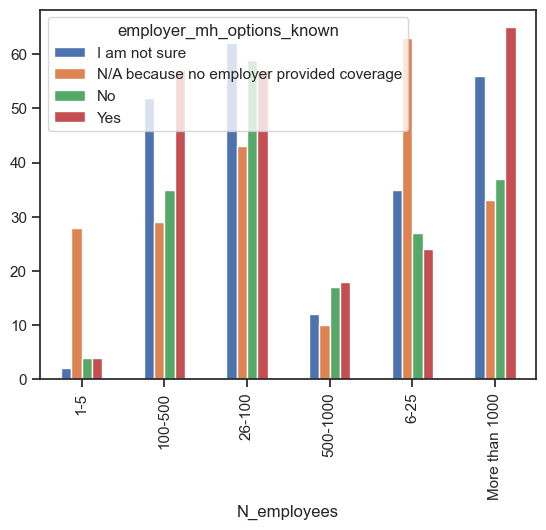

------------------------------------------
relative values:


employer_mh_options_known,I am not sure,N/A because no employer provided coverage,No,Yes
N_employees,,,,
1-5,0.052632,0.736842,0.105263,0.105263
100-500,0.300578,0.167630,0.202312,0.329480
26-100,0.280543,0.194570,0.266968,0.257919
500-1000,0.210526,0.175439,0.298246,0.315789
6-25,0.234899,0.422819,0.181208,0.161074
More than 1000,0.293194,0.172775,0.193717,0.340314


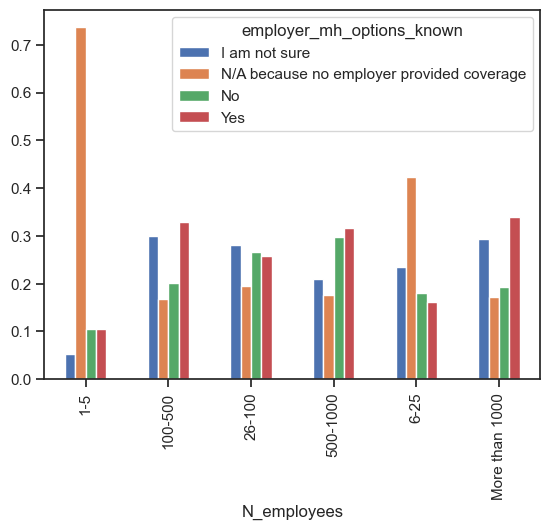

In [57]:
# the number of employees in the organization
f.show_pivot_tables_and_bars('N_employees', 'employer_mh_options_known', df_final)

Observations
* the proportion of individuals who know about the options provided by the employer increases almost monotonically with increasing company size: while in smaller companies only 11-15% know about the options, in larger companies this is the case for over 30% of individuals 

#### 7.2.5 Feeling Comfortable Sharing With Direct Supervisors/Coworkers and...

In [58]:
# expecting negative consequences after disclosure of a mental health issue
print('sharing with supervisors:')
calculate_kendall_tau('mh_disclosure_supervisor_comfortable', 'employer_neg_conseq_mh_disclosure_expected', df_final)
print('\nsharing with coworkers:')
calculate_kendall_tau('mh_disclosure_coworker_comfortable', 'employer_neg_conseq_mh_disclosure_expected', df_final)

sharing with supervisors:
Kendall's tau b rank correlation coefficient: -0.5197280897798695
p-value of the Kendall's tau b rank correlation coefficient: 1.887050302927639e-62

sharing with coworkers:
Kendall's tau b rank correlation coefficient: -0.4052574382607674
p-value of the Kendall's tau b rank correlation coefficient: 1.6533143215005402e-38


Observations
* both correlations are highly significant (p < .001) 
* the more individuals expect negative consequences after disclosure of a mental health problem, the less comfortable they feel sharing with supervisors and coworkers
* this correlation is slightly stronger for supervisors than for coworkers 

In [59]:
# age
print('sharing with supervisors:')
calculate_kendall_tau('mh_disclosure_supervisor_comfortable', 'age', df_final, scale_second=False)
print('\nsharing with coworkers:')
calculate_kendall_tau('mh_disclosure_coworker_comfortable', 'age', df_final, scale_second=False)

sharing with supervisors:
Kendall's tau b rank correlation coefficient: 0.03147581194415158
p-value of the Kendall's tau b rank correlation coefficient: 0.2494090841608737

sharing with coworkers:
Kendall's tau b rank correlation coefficient: 0.05042383902549848
p-value of the Kendall's tau b rank correlation coefficient: 0.0655933123584816


Observations:
* there is no significant correlation between age and willingness to discuss mental health problems with supervisors/coworkers (ps > .06)

In [60]:
# how seriously the employer takes mental health issues in comparison to physical health issues
print('sharing with supervisors:')
calculate_kendall_tau('mh_disclosure_supervisor_comfortable', 'seriousness_mh_physical_employer', df_final)
print('\nsharing with coworkers:')
calculate_kendall_tau('mh_disclosure_coworker_comfortable', 'seriousness_mh_physical_employer', df_final)

sharing with supervisors:
Kendall's tau b rank correlation coefficient: 0.39658471433712766
p-value of the Kendall's tau b rank correlation coefficient: 1.6604899270198405e-37

sharing with coworkers:
Kendall's tau b rank correlation coefficient: 0.2709107635020907
p-value of the Kendall's tau b rank correlation coefficient: 2.676460186866514e-18


Observations
* both correlations are highly significant (p < .001)
* the more seriously the employer takes mental health issues compared to physical health issues, the less comfortable employees feel sharing with supervisors and coworkers
* this correlation is slightly stronger for supervisors than for coworkers

absolute values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
neg_conseq_coworker_mh_disclosure_employer,,,
No,259,199,304
Yes,19,33,15


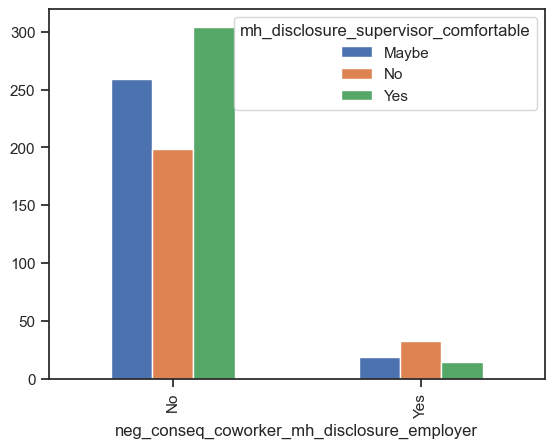

------------------------------------------
relative values:


mh_disclosure_supervisor_comfortable,Maybe,No,Yes
neg_conseq_coworker_mh_disclosure_employer,,,
No,0.339895,0.261155,0.398950
Yes,0.283582,0.492537,0.223881


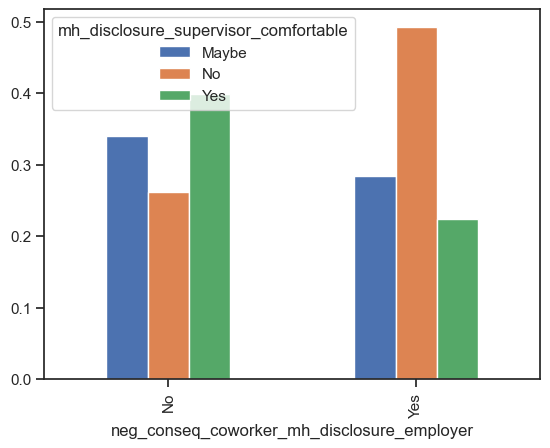

absolute values:


mh_disclosure_coworker_comfortable,Maybe,No,Yes
neg_conseq_coworker_mh_disclosure_employer,,,
No,333,240,189
Yes,22,32,13


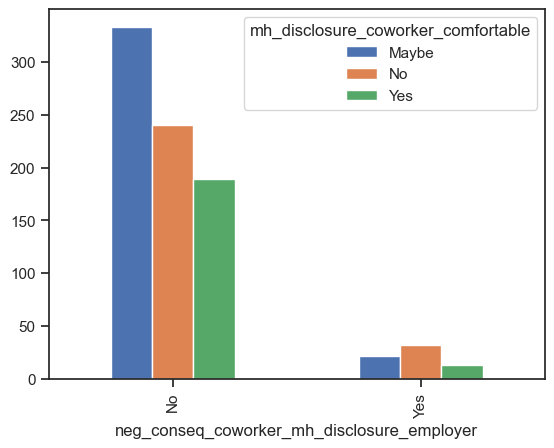

------------------------------------------
relative values:


mh_disclosure_coworker_comfortable,Maybe,No,Yes
neg_conseq_coworker_mh_disclosure_employer,,,
No,0.437008,0.314961,0.248031
Yes,0.328358,0.477612,0.194030


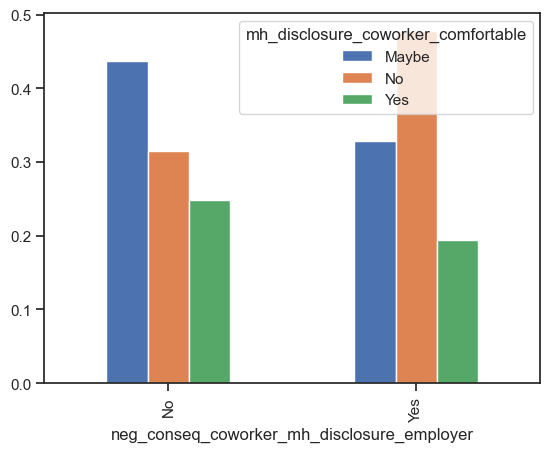

In [61]:
# whether negative consequences for coworkers were observed following disclosure of mental health issues 
f.show_pivot_tables_and_bars('neg_conseq_coworker_mh_disclosure_employer', 'mh_disclosure_supervisor_comfortable', df_final)
f.show_pivot_tables_and_bars('neg_conseq_coworker_mh_disclosure_employer', 'mh_disclosure_coworker_comfortable', df_final)

Observations
* more employees would feel comfortable sharing their mental health issues with their supervisor/coworkers if they did not observe negative consequences for others after sharing (40%/25%) than if they did (22%/19%)
* more employees would not feel comfortable sharing their mental health issues with their supervisor/coworkers if they did observe negative consequences for others after sharing (49%/48%) than if they did not (26%/31%)

In [62]:
# the feeling that disclosure of mental health issues would hurt the career
print('sharing with supervisors:')
calculate_kendall_tau('mh_disclosure_supervisor_comfortable', 'mh_disclosure_expected_neg_effect_career', df_final)
print('\nsharing with coworkers:')
calculate_kendall_tau('mh_disclosure_coworker_comfortable', 'mh_disclosure_expected_neg_effect_career', df_final)

sharing with supervisors:
Kendall's tau b rank correlation coefficient: -0.3659772268248317
p-value of the Kendall's tau b rank correlation coefficient: 2.6194374345337305e-31

sharing with coworkers:
Kendall's tau b rank correlation coefficient: -0.35075207375485196
p-value of the Kendall's tau b rank correlation coefficient: 8.902978289103926e-29


Observations
* both correlations are highly significant (ps < .001)
* the more employees assume that disclosure of mental health issues will hurt their career, the less likely they feel comfortable sharing their mental health issues with supervisors/coworkers

In [63]:
# current mental illnesses
print('sharing with supervisors:')
calculate_kendall_tau('mh_disclosure_supervisor_comfortable', 'self_mental_illness_present', df_final)
print('\nsharing with coworkers:')
calculate_kendall_tau('mh_disclosure_coworker_comfortable', 'self_mental_illness_present', df_final)

sharing with supervisors:
Kendall's tau b rank correlation coefficient: -0.04948353143767771
p-value of the Kendall's tau b rank correlation coefficient: 0.11576043371618078

sharing with coworkers:
Kendall's tau b rank correlation coefficient: -0.0051106256283409155
p-value of the Kendall's tau b rank correlation coefficient: 0.871233825138791


Observations
* there is no significant correlation between the presence of a current mental illness and feeling comfortable sharing mental health problems with supervisors/coworkers 

#### 7.2.6 Expecting Negative Consequences After Discussing a Mental Health Issue With the Employer and...

In [64]:
# expecting negative consequences after discussing a phyiscal health issue with the employer
calculate_kendall_tau('employer_neg_conseq_mh_disclosure_expected', 'employer_neg_conseq_physical_disclosure_expected', df_final)

Kendall's tau b rank correlation coefficient: 0.4856616811192482
p-value of the Kendall's tau b rank correlation coefficient: 1.8021618625589929e-50


Observations
* there is a highly significant (p < .001) positive correlation
* the more negative consequences employees expect after discussing a physical health issue, the more negative consequences they expect after discussing a mental health issue

In [65]:
# how seriously the employer takes mental health issues compared to physical health issues
calculate_kendall_tau('employer_neg_conseq_mh_disclosure_expected', 'seriousness_mh_physical_employer', df_final)

Kendall's tau b rank correlation coefficient: -0.4804655816054107
p-value of the Kendall's tau b rank correlation coefficient: 1.5419251469673628e-53


Observations
* there is a highly significant negative correlation (p < .001)
* the less seriously an employer takes mental problems compared to physical problems, the more likely employees are to expect negative consequences after disclosing a mental health problem 

#### 7.2.7 Protection of Anonymity When Taking Advantage of Mental Health or Substance Abuse Treatment and...

absolute values:


difficulty_asking_for_leave,Neither easy nor difficult,Somewhat difficult,Somewhat easy,Very difficult,Very easy
employer_anonymity_mh_benefits,,,,,
I don't know,123,79,86,40,65
N/A because no employer provided coverage,39,50,41,31,45
No,6,3,7,5,1
Yes,50,20,60,11,67


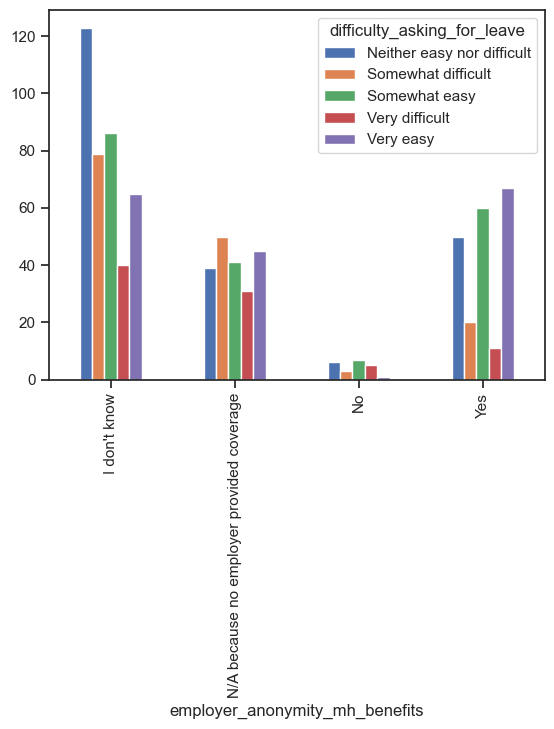

------------------------------------------
relative values:


difficulty_asking_for_leave,Neither easy nor difficult,Somewhat difficult,Somewhat easy,Very difficult,Very easy
employer_anonymity_mh_benefits,,,,,
I don't know,0.312977,0.201018,0.218830,0.101781,0.165394
N/A because no employer provided coverage,0.189320,0.242718,0.199029,0.150485,0.218447
No,0.272727,0.136364,0.318182,0.227273,0.045455
Yes,0.240385,0.096154,0.288462,0.052885,0.322115


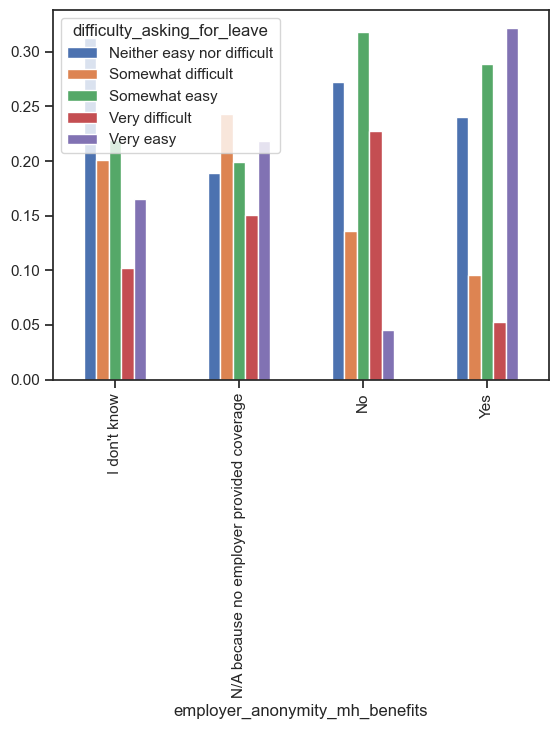

In [66]:
# the difficulty of asking for a medical leave due to a mental health issue 
f.show_pivot_tables_and_bars('employer_anonymity_mh_benefits', 'difficulty_asking_for_leave', df_final)

Observations
* when anonymity is protected, most individuals (32%) find it "very easy" to ask for a medical leave and only few (5%) find it "very difficult"
* when anonymity is not protected, more individuals find it "very difficult" (23%) than "very easy" (5%), but still most individuals find it "somewhat easy" (32%); however, due to the small sample size, this interpretation should be viewed with caution

#### 7.2.8 Willingness to Disclose Mental Problems in a Job Interview and...

In [67]:
# willingness to disclose physical problems in a job interview
calculate_kendall_tau('willingness_mh_disclosure_interview', 'willingness_physical_disclosure_interview', df_final)

Kendall's tau b rank correlation coefficient: 0.48378083589058524
p-value of the Kendall's tau b rank correlation coefficient: 7.477705352046283e-52


Observations
* there is a highly significant positive correlation (p < .001): the more individuals are willing to disclose physical health problems in an interview, the more they are willing to disclose mental health issues in an interview 

In [68]:
# having observed a negative or inappropriate responses to a mental health issue
calculate_kendall_tau('willingness_mh_disclosure_interview', 'mh_neg_effect_workplace_observed', df_final)

Kendall's tau b rank correlation coefficient: -0.11790393513074472
p-value of the Kendall's tau b rank correlation coefficient: 0.00022637383723816823


Observations
* there is a highly significant negative correlation (p < .001): the more certain individuals are of hanving observed or experienced negative or inappropriate reactions toward a mental health problem, the less willing they are to be open about mental ehalth problems in a job interview 

#### 7.2.9 Feeling That Being Identified as a Person With Mental Health Issues Has a Negative Effect on the Career and...

In [69]:
# the expectation that one would be viewed more negatively by coworkers after disclosure of a mental health issue 
calculate_kendall_tau('mh_disclosure_expected_neg_effect_career', 'mh_disclosure_expected_neg_view_coworkers', df_final)

Kendall's tau b rank correlation coefficient: 0.5395596265745276
p-value of the Kendall's tau b rank correlation coefficient: 6.135903921614464e-66


Observation
* there is a highly significant positive correlation (p < .001): the more individuals assume that identifying as a person with mental health problems is detrimental to one's career, the more they also assume that coworkers would view one more negatively if they knew one had a mental health disorder

In [70]:
# expecting a negative or inappropriate response to a mental health issue
calculate_kendall_tau('mh_disclosure_expected_neg_effect_career', 'mh_neg_effect_workplace_observed', df_final)

Kendall's tau b rank correlation coefficient: 0.2603334440756764
p-value of the Kendall's tau b rank correlation coefficient: 1.5631773927644493e-16


Observations
* there is a highly significant positve correlation (p < .001): the more individuals assume that identifying as a person with mental health problems is detrimental to one's career, the more they expect negative or inappropriate responses to a mental health issue

absolute values:


mh_disclosure_expected_neg_effect_career,Maybe,No,Yes
"(1) Anxiety Disorder (Generalized, Social, Phobia, etc)",,,
0.0,255,69,263
1.0,83,38,121


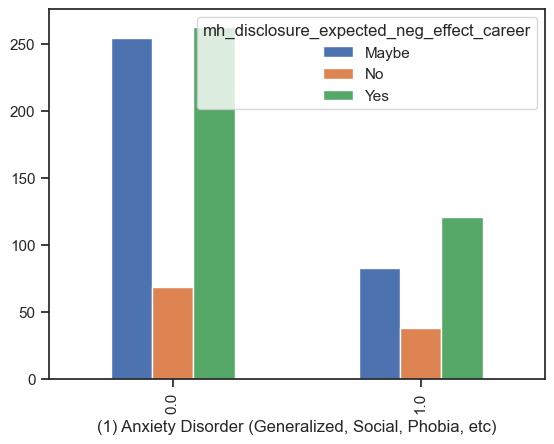

------------------------------------------
relative values:


mh_disclosure_expected_neg_effect_career,Maybe,No,Yes
"(1) Anxiety Disorder (Generalized, Social, Phobia, etc)",,,
0.0,0.434412,0.117547,0.448041
1.0,0.342975,0.157025,0.500000


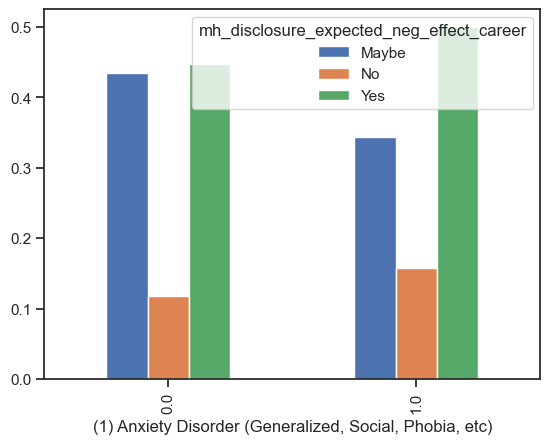

In [71]:
# anxiety
f.show_pivot_tables_and_bars('(1) Anxiety Disorder (Generalized, Social, Phobia, etc)', 'mh_disclosure_expected_neg_effect_career', df_final)

Observations
* individuals with anxiety disorder do not differ much from individuals without anxiety disorder when it comes to the belief that identifying as a person with mental health issues is detrimental to one's career

absolute values:


mh_disclosure_expected_neg_effect_career,Maybe,No,Yes
"(1) Mood Disorder (Depression, Bipolar Disorder, etc)",,,
0.0,230,60,240
1.0,108,47,144


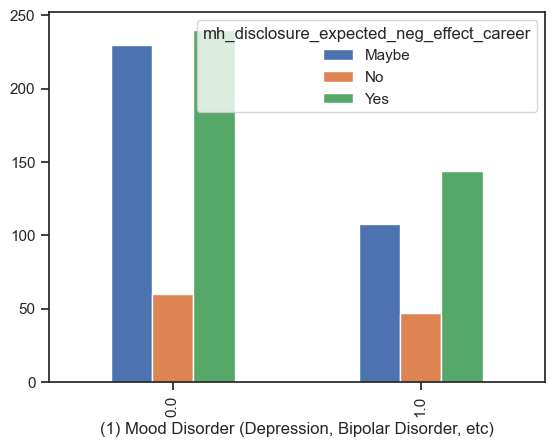

------------------------------------------
relative values:


mh_disclosure_expected_neg_effect_career,Maybe,No,Yes
"(1) Mood Disorder (Depression, Bipolar Disorder, etc)",,,
0.0,0.433962,0.113208,0.452830
1.0,0.361204,0.157191,0.481605


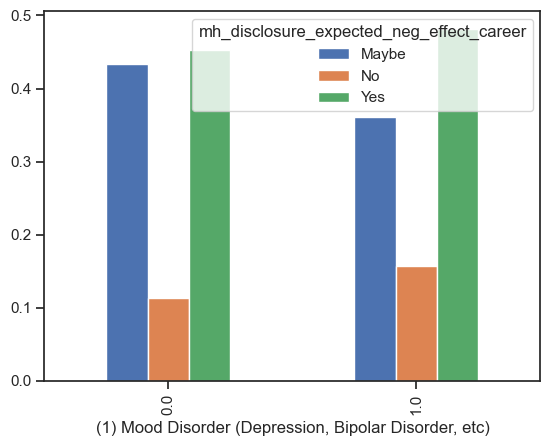

In [72]:
# mood disorder
f.show_pivot_tables_and_bars('(1) Mood Disorder (Depression, Bipolar Disorder, etc)', 'mh_disclosure_expected_neg_effect_career', df_final)

Observations
* individuals with mood disorder do not differ much from individuals without mood disorder when it comes to the belief that identifying as a person with mental health issues is detrimental to one's career

#### 7.2.10 The Expectation That Coworkers Would View One More Negatively After Disclosing a Mental Health Issue and ...

In [73]:
# the willingness to disclose the mental health issue to coworkers
calculate_kendall_tau('mh_disclosure_coworker_comfortable', 'mh_disclosure_expected_neg_view_coworkers', df_final)

Kendall's tau b rank correlation coefficient: -0.41784323066375545
p-value of the Kendall's tau b rank correlation coefficient: 2.586720966631541e-41


Observations
* there is a highly significant negative correlation (p < .001): the less individuals feel that coworkers would view them more negatively after disclosure of mental health issues, the more comfortable they feel sharing their mental health issues with coworkers

In [74]:
# observing a negative or inappropriate response to a mental health issue
calculate_kendall_tau('mh_disclosure_expected_neg_view_coworkers', 'mh_neg_effect_workplace_observed', df_final)

Kendall's tau b rank correlation coefficient: 0.22349050424579078
p-value of the Kendall's tau b rank correlation coefficient: 6.367723269686384e-13


Observations
* there is a highly significant positive correlation (p < .001): the more individuals observed negative or inappropriate responses to a mental health issue, the more they believe that coworkers would view them more negatively after disclosure of a mental health problem 

absolute values:


mh_disclosure_expected_neg_view_coworkers,Maybe,No,Yes
"(1) Anxiety Disorder (Generalized, Social, Phobia, etc)",,,
0.0,237,190,160
1.0,99,72,71


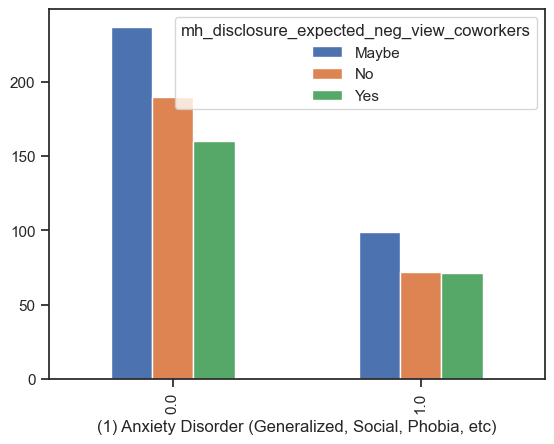

------------------------------------------
relative values:


mh_disclosure_expected_neg_view_coworkers,Maybe,No,Yes
"(1) Anxiety Disorder (Generalized, Social, Phobia, etc)",,,
0.0,0.403748,0.323680,0.272572
1.0,0.409091,0.297521,0.293388


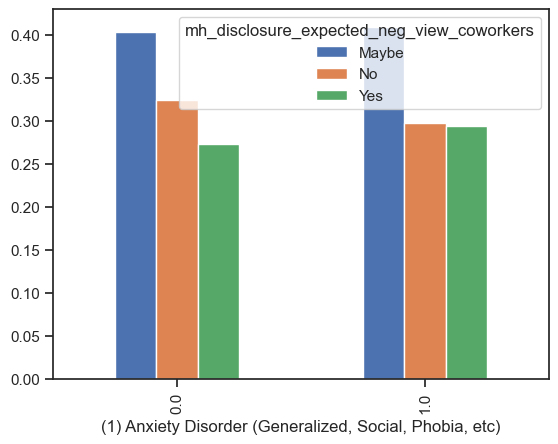

In [75]:
# anxiety
f.show_pivot_tables_and_bars('(1) Anxiety Disorder (Generalized, Social, Phobia, etc)', 'mh_disclosure_expected_neg_view_coworkers', df_final)

Observation
* there are no major differences between individuals with anxiety disorder and individuals without anxiety disorder in terms of the belief that coworkers would view one more negatively after disclosing a mental health problem

## 8 Feature Encoding

* to be able to apply machine learning algorithms, categorical variables have to be transformed into numerical variables (Zheng & Casari, 2018, p. 78)
* numerically encode ordinally and nominally scaled variables

In [76]:
# create a copy of the dataset containing the final sample
df_enc = df_final.copy()

### 8.1 Ordinally Scaled Features

In [77]:
# create a new data dictionary
data_dict_v4 = f.create_data_dict(df_final)

# display all ordinally scaled features
pd.set_option('display.max_colwidth', None) # to show the whole cell content 
dict_ordinal = data_dict_v4.loc[data_dict_v4['data_types'] == 'ordinal'].copy()
dict_ordinal

,variable,unique_values,uniques_count,data_types,missing_count,missing_percent,dk_count,dk_percent,n/a_count,n/a_percent
1,N_employees,"[26-100, 6-25, More than 1000, 100-500, 500-1000, 1-5]",6,ordinal,0,0.0,0,0.000000,0,0.0
5,employer_mh_formally_discussed,"[No, Yes, I don't know]",3,ordinal,0,0.0,78,0.094089,0,0.0
6,employer_mh_ressources_offered,"[No, Yes, I don't know]",3,ordinal,0,0.0,229,0.276236,0,0.0
8,difficulty_asking_for_leave,"[Very easy, Somewhat easy, Neither easy nor difficult, Very difficult, Somewhat difficult]",5,ordinal,0,0.0,0,0.000000,0,0.0
9,employer_neg_conseq_mh_disclosure_expected,"[No, Yes, Maybe]",3,ordinal,0,0.0,0,0.000000,0,0.0
10,employer_neg_conseq_physical_disclosure_expected,"[No, Maybe, Yes]",3,ordinal,0,0.0,0,0.000000,0,0.0
11,mh_disclosure_coworker_comfortable,"[Maybe, Yes, No]",3,ordinal,0,0.0,0,0.000000,0,0.0
12,mh_disclosure_supervisor_comfortable,"[Yes, No, Maybe]",3,ordinal,0,0.0,0,0.000000,0,0.0
13,seriousness_mh_physical_employer,"[I don't know, Yes, No]",3,ordinal,0,0.0,344,0.414958,0,0.0
16,willingness_physical_disclosure_interview,"[Maybe, Yes, No]",3,ordinal,0,0.0,0,0.000000,0,0.0


In [78]:
# create a data frame containing only ordinally scaled features
df_ordinal = df_enc[dict_ordinal['variable'].tolist()].copy()

# encode ordinally scaled features numerically by replacing the categories with numbers
df_ordinal_enc = df_ordinal.replace({'No': 0, 'Maybe': 1, 'Yes': 2, 
                                     'Maybe/Not sure': 1, 
                                     'I don\'t know': 1,
                                     '1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5,
                                     'Never': 0, 'Sometimes': 1, 'Always': 2, 
                                     'Very easy': 0, 'Somewhat easy': 1, 'Neither easy nor difficult': 2, 'Somewhat difficult': 3, 'Very difficult': 4}).copy()

In [79]:
# replace the ordinally scaled variables with the encoded variables
df_enc[df_ordinal_enc.columns] = df_ordinal_enc.copy()

### 8.2 Nominally Scaled Features

In [80]:
# create a data frame containing only nominally scaled features
dict_nominal = data_dict_v4.loc[(data_dict_v4['data_types'] == 'nominal')].copy()
df_nominal = df_enc[dict_nominal['variable'].tolist()].copy()

# for variables with only "yes" and "no" answer options, recode "yes" to 1 and "no" to 0
yes_no_variables = dict_nominal[dict_nominal['unique_values'].str.contains('Yes', na=False, regex=False) & (dict_nominal['uniques_count'] == 2)]['variable'].tolist()
df_nominal_rec = df_nominal.copy()
df_nominal_rec[yes_no_variables] = df_nominal[yes_no_variables].replace({'No': 0, 'Yes': 1}).copy()

In [81]:
# one-hot encode nominally scaled features
df_nominal_ohe = pd.get_dummies(df_nominal_rec)

In [82]:
# add the one-hot encoded variables to the data frame and drop the old variables
pd.reset_option('display.max_colwidth')
print('shape before dropping nominal variables:', df_enc.shape)
df_enc.drop(columns=df_nominal.columns, inplace=True)
print('shape after dropping nominal variables:', df_enc.shape)

df_enc = pd.concat([df_enc, df_nominal_ohe], axis=1)
print('shape after adding one-hot encoded variables:', df_enc.shape)

shape before dropping nominal variables: (829, 134)
shape after dropping nominal variables: (829, 30)
shape after adding one-hot encoded variables: (829, 166)


In [83]:
# create a final data dictionary of the numerically encoded variables
data_dict_v8 = f.create_data_dict(df_enc)
pd.reset_option('display.max_colwidth') # to reset the maximum colwidth to the default value 
data_dict_v8

,variable,unique_values,uniques_count,data_types,missing_count,missing_percent,dk_count,dk_percent,n/a_count,n/a_percent
0,N_employees,"[2, 1, 5, 3, 4, 0]",6,ordinal,0,0.0,0,0.0,0,0.0
1,employer_mh_formally_discussed,"[0, 2, 1]",3,ordinal,0,0.0,0,0.0,0,0.0
2,employer_mh_ressources_offered,"[0, 2, 1]",3,ordinal,0,0.0,0,0.0,0,0.0
3,difficulty_asking_for_leave,"[0, 1, 2, 4, 3]",5,ordinal,0,0.0,0,0.0,0,0.0
4,employer_neg_conseq_mh_disclosure_expected,"[0, 2, 1]",3,ordinal,0,0.0,0,0.0,0,0.0
5,employer_neg_conseq_physical_disclosure_expected,"[0, 1, 2]",3,ordinal,0,0.0,0,0.0,0,0.0
6,mh_disclosure_coworker_comfortable,"[1, 2, 0]",3,ordinal,0,0.0,0,0.0,0,0.0
7,mh_disclosure_supervisor_comfortable,"[2, 0, 1]",3,ordinal,0,0.0,0,0.0,0,0.0
8,seriousness_mh_physical_employer,"[1, 2, 0]",3,ordinal,0,0.0,0,0.0,0,0.0
9,willingness_physical_disclosure_interview,"[1, 2, 0]",3,ordinal,0,0.0,0,0.0,0,0.0


Observation
* all features are now numerical

In [84]:
# save the final data frame as csv
df_enc.to_csv('df_enc.csv', encoding='utf-8', index=False)